## Explore SIS on Beer Review Sentiment Data
### Aspect 1: Aroma

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import os
import sys
import pandas as pd
sys.path.insert(0, os.path.abspath('../'))

from keras.models import load_model
from scipy.stats import linregress, ranksums, ttest_ind, spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score

import sis as sis
import clustering
import sis_visualizations as visualizations
import lime_helper as lime_helper
from rationale_objects import Rationale, BeerReview, BeerReviewContainer, \
                              SIS_RATIONALE_KEY, IG_SUFF_RATIONALE_KEY, LIME_SUFF_RATIONALE_KEY, \
                              PERTURB_SUFF_RATIONALE_KEY, LIME_FIXED_RATIONALE_KEY, \
                              IG_FIXED_RATIONALE_KEY, PERTURB_FIXED_RATIONALE_KEY
from packages.IntegratedGradients.IntegratedGradients import integrated_gradients

from IPython.core.display import display, HTML

In [3]:
sis.tf_config(cuda_visible_devices='2')

In [4]:
figures_dir = '../figures/beer_asp1_aroma'

In [6]:
# Load beer review data for a particular aspect

ASPECT = 1  # 0, 1, 2, or 3

BASE_PATH = '../data/beer_reviews'

path = os.path.join(BASE_PATH, 'reviews.aspect' + str(ASPECT))
train_path = path + '.train.txt.gz'
heldout_path = path + '.heldout.txt.gz'

X_train_texts, y_train = sis.load_reviews(train_path)
X_test_texts, y_test = sis.load_reviews(heldout_path)

# y value is just the sentiment for this aspect, throw away the other scores
y_train = np.array([y[ASPECT] for y in y_train])
y_test = np.array([y[ASPECT] for y in y_test])

# Create a 3k validation set held-out from the test set
X_test_texts, X_val_texts, y_test, y_val = sis.create_splits(X_test_texts, y_test)

70000 examples loaded from ../data/beer_reviews/reviews.aspect1.train.txt.gz
max text length: 5085
10000 examples loaded from ../data/beer_reviews/reviews.aspect1.heldout.txt.gz
max text length: 4619


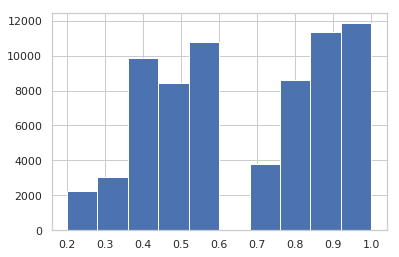

Unique y values:  [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Mean y value:  0.6802100000000001
Median y value:  0.7
Std y value:  0.23792000195143623


In [7]:
plt.hist(y_train)
plt.show()

print('Unique y values: ', np.unique(y_train))
print('Mean y value: ', np.mean(y_train))
print('Median y value: ', np.median(y_train))
print('Std y value: ', np.std(y_train))

Review length:
Mean 154.47 words (stddev: 81.134751)


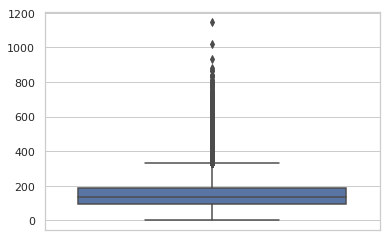

In [8]:
print('Review length:')
train_texts_lengths = [len(x.split(' ')) for x in X_train_texts]
print("Mean %.2f words (stddev: %f)" % \
      (np.mean(train_texts_lengths),
       np.std(train_texts_lengths)))

# plot review lengths
sns.boxplot(train_texts_lengths, orient='v')
plt.show()

In [9]:
# Tokenize the texts and keep only the top n words

TOP_WORDS = 10000

tokenizer = sis.create_tokenizer(X_train_texts, top_words=TOP_WORDS)

X_train = tokenizer.texts_to_sequences(X_train_texts)
X_val = tokenizer.texts_to_sequences(X_val_texts)
X_test = tokenizer.texts_to_sequences(X_test_texts)

print(len(X_train))
print(len(X_val))
print(len(X_test))

70000
3000
7000


In [10]:
index_to_token = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}

In [11]:
# Bound reviews at 500 words, truncating longer reviews and zero-padding shorter reviews

MAX_WORDS = 500

X_train = sis.pad_sequences(X_train, max_words=MAX_WORDS)
X_val = sis.pad_sequences(X_val, max_words=MAX_WORDS)
X_test = sis.pad_sequences(X_test, max_words=MAX_WORDS)

## Confirm mean embedding as replacement is appropriate

In [94]:
top_words = []
counts = []
for word, _ in tokenizer.word_index.items():
    top_words.append(word)
    counts.append(tokenizer.word_counts[word])
    if len(top_words) == TOP_WORDS - 1:
        break
counts = np.array(counts, dtype='float64')
probs = counts / counts.sum()
assert(probs.sum() == 1)

In [95]:
def get_random_words(probs, size=1):
    word_idxs = np.arange(1, 10000)
    return np.random.choice(word_idxs, size=size, replace=True, p=probs)

In [2513]:
def replacement_sampling_vs_mean(embeddings, X, word_probs, embed_model, num_trials=1000):
    mean_embed = np.mean(embeddings, axis=0)
    X_examples = np.random.choice(len(X), size=num_trials, replace=True)
    word_replacements = get_random_words(word_probs, size=num_trials)
    
    mean_replace_inputs = []
    vocab_sample_replace_inputs = []
    original_inputs = []
    
    for i, replacement_word in zip(X_examples, word_replacements):
        x = X[i]
        num_pad = np.count_nonzero(x == 0)
        x_length = len(x) - num_pad
        idx_to_replace = num_pad + np.random.choice(x_length)
        x_embed = embeddings[x]
        original_inputs.append(x_embed)
        x_mean_replace = x_embed.copy()
        x_mean_replace[idx_to_replace] = mean_embed
        mean_replace_inputs.append(x_mean_replace)
        x_vocab_sample_replace = x_embed.copy()
        x_vocab_sample_replace[idx_to_replace] = embeddings[replacement_word]
        vocab_sample_replace_inputs.append(x_vocab_sample_replace)        
    
    mean_preds = sis.predict_for_embed_sequence(mean_replace_inputs, embed_model)
    vocab_sample_preds = sis.predict_for_embed_sequence(vocab_sample_replace_inputs, embed_model)
    original_preds = sis.predict_for_embed_sequence(original_inputs, embed_model)

    mean_deltas = mean_preds - original_preds
    vocab_sample_deltas = vocab_sample_preds - original_preds
    
    return mean_deltas, vocab_sample_deltas

mean_deltas, vocab_sample_deltas = replacement_sampling_vs_mean(embeddings, X_train, probs, embed_model,
                                                                num_trials=10000)

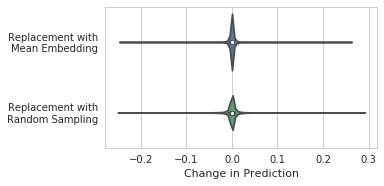

--- Mean Embedding ---
Mean: -7.0e-04
Median: -4.3e-05
Std: 0.013

--- Random Sampling ---
Mean: -7.4e-04
Median: -4.9e-06
Std: 0.018


In [2528]:
replacement_sampling_df = pd.DataFrame({'Replacement with\nMean Embedding': mean_deltas,
                                        'Replacement with\nRandom Sampling': vocab_sample_deltas})

plt.figure(figsize=(5.5, 2.75))
sns.violinplot(data=replacement_sampling_df, orient='h')
plt.xlabel('Change in Prediction')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'mean_replacement.png'), dpi=1200, bbox_inches='tight')
plt.show()


print('--- Mean Embedding ---')
print('Mean: %.1e' % np.mean(mean_deltas))
print('Median: %.1e' % np.median(mean_deltas))
print('Std: %.3f' % np.std(mean_deltas))
print()
print('--- Random Sampling ---')
print('Mean: %.1e' % np.mean(vocab_sample_deltas))
print('Median: %.1e' % np.median(vocab_sample_deltas))
print('Std: %.3f' % np.std(vocab_sample_deltas))

## Load trained LSTM RNN model

In [12]:
# Load a pre-trained model

model_path = '../trained_models/asp%d_lstm.hdf5' % ASPECT

model = load_model(model_path,
                   custom_objects={'coeff_determination_metric': sis.coeff_determination_metric})
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 500, 200)          240800    
_________________________________________________________________
lstm_10 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 1,561,801
Trainable params: 1,561,801
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# Evaluate model (for paper supplement)

train_preds = model.predict(X_train, verbose=1, batch_size=128)
val_preds = model.predict(X_val, verbose=1, batch_size=128)
test_preds = model.predict(X_test, verbose=1, batch_size=128)
annot_preds = model.predict(X_annotation, verbose=1, batch_size=128)

train_preds = train_preds.flatten()
val_preds = val_preds.flatten()
test_preds = test_preds.flatten()
annot_preds = annot_preds.flatten()

994/994 [==============================] - 9s 9ms/step


In [39]:
# Compute MSE and R^2 for each set
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)
train_correl = pearsonr(y_train, train_preds)[0]

val_mse = mean_squared_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)
val_correl = pearsonr(y_val, val_preds)[0]

test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
test_correl = pearsonr(y_test, test_preds)[0]

annot_mse = mean_squared_error(y_annotation, annot_preds)
annot_r2 = r2_score(y_annotation, annot_preds)
annot_correl = pearsonr(y_annotation, annot_preds)[0]

# Rows for latex table
print('& Train & %d & %.3f & %.3f  \\\ ' % (len(X_train), train_mse, train_correl))
print('& Validation & %d & %.3f & %.3f  \\\ ' % (len(X_val), val_mse, val_correl))
print('& Test & %d & %.3f & %.3f  \\\ ' % (len(X_test), test_mse, test_correl))
print('& Annotation & %d & %.3f & %.3f  \\\ ' % (len(X_annotation), annot_mse, annot_correl))

& Train & 70000 & 0.014 & 0.873  \\ 
& Validation & 3000 & 0.024 & 0.767  \\ 
& Test & 7000 & 0.025 & 0.756  \\ 
& Annotation & 994 & 0.021 & 0.598  \\ 


## SIS Deletion Algorithm

In [11]:
embed_model = sis.make_lstm_model_feed_embeddings()
sis.copy_layer_weights(model, embed_model)
print(embed_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 500, 200)          240800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 561,801
Trainable params: 561,801
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# Make sure the models function the same, but testing the output for some input

embeddings = sis.get_embeddings(model)

X_new = embeddings[X_train[0]]

print(model.predict(np.array([X_train[0]])))
print(embed_model.predict(np.array(X_new).reshape((1, X_new.shape[0], X_new.shape[1]))))

[[0.9140035]]
[[0.9140035]]


In [13]:
# Try predicting the model on a series of all zeros
print('All zeros:',
      sis.predict_for_embed_sequence([np.zeros((500, 100))], embed_model))

# Try predicting the model on a series of all pad characters
pad_embedding = embeddings[0]
print('All pad:',
      sis.predict_for_embed_sequence([np.repeat(pad_embedding.reshape((1, pad_embedding.shape[0])), 500, axis=0)], embed_model))

# Try on a series of all mean embedding vectors
mean_embedding = np.mean(embeddings, axis=0)
print('All mean embedding:',
      sis.predict_for_embed_sequence([np.repeat(mean_embedding.reshape((1, mean_embedding.shape[0])), 500, axis=0)], embed_model))

All zeros: [0.5872434]
All pad: [0.51664615]
All mean embedding: [0.5509751]


## Load annotated examples

In [13]:
RATIONALE_ANNOTATION_PATH = os.path.join(BASE_PATH, 'annotations.json')
annotations = sis.load_rationale_annotations(RATIONALE_ANNOTATION_PATH)

Loaded 994 annotations.


In [14]:
X_annotation = [sis.retokenize_annotation(annot['x'], tokenizer)[0] for annot in annotations]
X_annotation = sis.pad_sequences(X_annotation)

y_annotation = np.array([float(annot['y'][ASPECT]) for annot in annotations])

In [15]:
# Count number of annotated rationales also present in training set

overlaps = 0
overlap_indices = []
X_annotation_set = set((tuple(x) for x in X_annotation))

for i, x in enumerate(X_train):
    if tuple(x) in X_annotation_set:
        overlaps += 1
    overlap_indices.append(i)

print('# Overlaps: ', overlaps)

# Overlaps:  0


## Determine which of the annotation examples are predicted "interesting"

In [17]:
original_predictions = model.predict(X_annotation)

Mean:  0.7040175
Median:  0.6942415
Stdev:  0.16733527

Num >= 0.85: 271
Num <= 0.45: 66


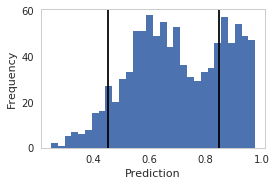

In [20]:
pos_threshold = 0.85
neg_threshold = 0.45

threshold_pos_f = lambda x: x >= pos_threshold
threshold_neg_f = lambda x: x <= neg_threshold

pos_example_idxs = np.flatnonzero(original_predictions >= pos_threshold)
neg_example_idxs = np.flatnonzero(original_predictions <= neg_threshold)

print('Mean: ', np.mean(original_predictions))
print('Median: ', np.median(original_predictions))
print('Stdev: ', np.std(original_predictions))
print('')
print('Num >= %.2f: %d' % (pos_threshold, len(pos_example_idxs)))
print('Num <= %.2f: %d' % (neg_threshold, len(neg_example_idxs)))

plt.figure(figsize=(4, 2.75))
plt.hist(original_predictions, bins=30)
plt.axvline(x=pos_threshold, c='black')
plt.axvline(x=neg_threshold, c='black')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'predictive_dist.png'), dpi=1200, bbox_inches='tight')
plt.show()

## Compute/load rationales on the "interesting" examples

In [16]:
BRC_DIR = '../rationale_results/beer_reviews/asp%d' % ASPECT

In [23]:
# Create new BeerReviewContainer
brc = BeerReviewContainer(embeddings, index_to_token, ASPECT, model_path, 0)

In [17]:
# Load container and reviews/rationales from directory
brc = BeerReviewContainer.load_data(BRC_DIR)

In [24]:
# Create BeerReview objects from the existing data structures

for i in pos_example_idxs:
    x = X_annotation[i]
    review = BeerReview(x, i, embeddings=embeddings)
    annot_idxs = sis.get_annot_idxs(i, annotations, tokenizer, ASPECT)
    review.set_annotation_idxs(annot_idxs)
    review.threshold = pos_threshold
    review.threshold_f = threshold_pos_f
    review.is_pos = True
    brc.add_pos_review(review)

for i in neg_example_idxs:
    x = X_annotation[i]
    review = BeerReview(x, i, embeddings=embeddings)
    annot_idxs = sis.get_annot_idxs(i, annotations, tokenizer, ASPECT)
    review.set_annotation_idxs(annot_idxs)
    review.threshold = neg_threshold
    review.threshold_f = threshold_neg_f
    review.is_pos = False
    brc.add_neg_review(review)

In [30]:
# Compute all SIS rationales for each review
for review in brc.get_all_reviews():
    review.run_sis_rationales(embed_model, first_only=False, verbose=False)

In [29]:
# Run integrated gradients on all reviews
for r in brc.get_all_reviews():
    r.run_integrated_gradients_rationale(ig, embed_model, igs_baseline)

In [31]:
# Compute predictions on (non/)rationales only, (non/)annotations only, etc.
#   Only mask first rationale in rationale hold-outs
for r in brc.get_all_reviews():
    rationales = [r.get_rationales(SIS_RATIONALE_KEY)[0]]  # only first rationale for masking
    r.set_predictions(embed_model, rationales)

In [44]:
# Dump container and all reviews/rationales to directory
brc.dump_data(BRC_DIR)

## Analysis of Rationale lengths

In [30]:
rationale_len_sis_pos = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) \
                                         for r in brc.get_pos_reviews()])
rationale_len_sis_neg = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) \
                                         for r in brc.get_neg_reviews()])

rationale_len_sis = np.concatenate((rationale_len_sis_pos, rationale_len_sis_neg))

rationale_len_sis_pos_percentage = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_sis_neg_percentage = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_sis_percentage = np.concatenate((rationale_len_sis_pos_percentage, \
                                                  rationale_len_sis_neg_percentage))

rationale_len_sis_percentage_allsuffic = []
for review in brc.get_all_reviews():
    num_tokens = review.get_num_tokens()
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        rationale_len_sis_percentage_allsuffic.append(len(r) / float(num_tokens) * 100.0)
rationale_len_sis_percentage_allsuffic = np.array(rationale_len_sis_percentage_allsuffic)

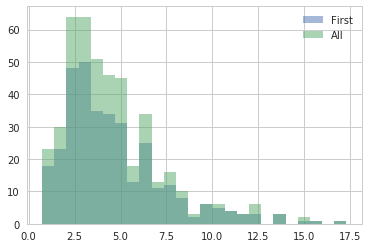

In [31]:
plt.hist(rationale_len_sis_percentage, bins=25, alpha=0.5, label='First')
plt.hist(rationale_len_sis_percentage_allsuffic, bins=25, alpha=0.5, label='All')
plt.legend(loc='upper right')
plt.show()

Rationale Lengths, SIS:
Mean:  4.732937685459941
Median:  5.0
Stdev:  1.8213735903874348
Min:  1
Max:  10


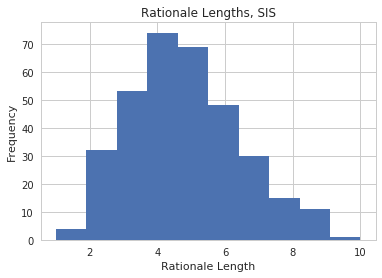

Rationale Lengths, SIS (as percentage of input length):
Mean:  4.619851985142102
Median:  3.937007874015748
Stdev:  2.822731685447188
Min:  0.7246376811594203
Max:  17.307692307692307


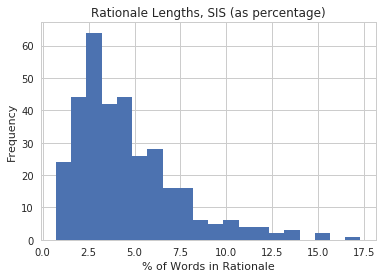

In [32]:
print('Rationale Lengths, SIS:')
print('Mean: ', np.mean(rationale_len_sis))
print('Median: ', np.median(rationale_len_sis))
print('Stdev: ', np.std(rationale_len_sis))
print('Min: ', np.min(rationale_len_sis))
print('Max: ', np.max(rationale_len_sis))

plt.hist(rationale_len_sis, bins=10)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, SIS')
plt.show()

print('Rationale Lengths, SIS (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_sis_percentage))
print('Median: ', np.median(rationale_len_sis_percentage))
print('Stdev: ', np.std(rationale_len_sis_percentage))
print('Min: ', np.min(rationale_len_sis_percentage))
print('Max: ', np.max(rationale_len_sis_percentage))

plt.hist(rationale_len_sis_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, SIS (as percentage)')
plt.show()

In [33]:
rationale_len_ig_pos = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_ig_neg = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_ig = np.concatenate((rationale_len_ig_pos, rationale_len_ig_neg))

rationale_len_ig_pos_percentage = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_ig_neg_percentage = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_ig_percentage = np.concatenate((rationale_len_ig_pos_percentage, \
                                              rationale_len_ig_neg_percentage))

Rationale Lengths, Integrated Gradients:
Mean:  12.178041543026707
Median:  9.0
Stdev:  13.394861221516061
Min:  1
Max:  119


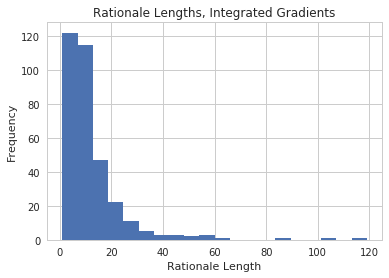

Rationale Lengths, Integrated Gradients (as percentage of input length):
Mean:  11.557564753627096
Median:  7.6923076923076925
Stdev:  13.02092180288771
Min:  0.9174311926605505
Max:  89.69072164948454


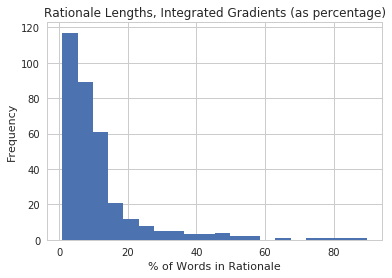

In [34]:
print('Rationale Lengths, Integrated Gradients:')
print('Mean: ', np.mean(rationale_len_ig))
print('Median: ', np.median(rationale_len_ig))
print('Stdev: ', np.std(rationale_len_ig))
print('Min: ', np.min(rationale_len_ig))
print('Max: ', np.max(rationale_len_ig))

plt.hist(rationale_len_ig, bins=20)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Integrated Gradients')
plt.show()

print('Rationale Lengths, Integrated Gradients (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_ig_percentage))
print('Median: ', np.median(rationale_len_ig_percentage))
print('Stdev: ', np.std(rationale_len_ig_percentage))
print('Min: ', np.min(rationale_len_ig_percentage))
print('Max: ', np.max(rationale_len_ig_percentage))

plt.hist(rationale_len_ig_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Integrated Gradients (as percentage)')
plt.show()

In [35]:
rationale_len_lime_pos = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_lime_neg = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_lime = np.concatenate((rationale_len_lime_pos, rationale_len_lime_neg))

rationale_len_lime_pos_percentage = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_lime_neg_percentage = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_lime_percentage = np.concatenate((rationale_len_lime_pos_percentage, \
                                                rationale_len_lime_neg_percentage))

Rationale Lengths, LIME:
Mean:  12.522255192878339
Median:  8.0
Stdev:  14.640304828722089
Min:  1
Max:  127


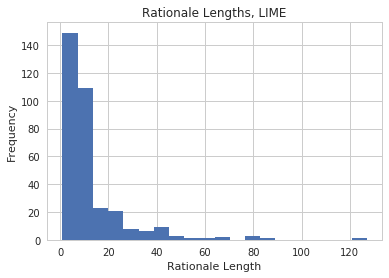

Rationale Lengths, LIME (as percentage of input length):
Mean:  11.901275355795796
Median:  7.042253521126761
Stdev:  14.762977607983046
Min:  0.7246376811594203
Max:  100.0


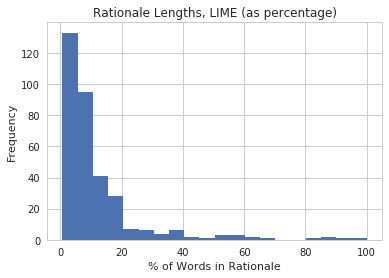

In [36]:
print('Rationale Lengths, LIME:')
print('Mean: ', np.mean(rationale_len_lime))
print('Median: ', np.median(rationale_len_lime))
print('Stdev: ', np.std(rationale_len_lime))
print('Min: ', np.min(rationale_len_lime))
print('Max: ', np.max(rationale_len_lime))

plt.hist(rationale_len_lime, bins=20)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, LIME')
plt.show()

print('Rationale Lengths, LIME (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_lime_percentage))
print('Median: ', np.median(rationale_len_lime_percentage))
print('Stdev: ', np.std(rationale_len_lime_percentage))
print('Min: ', np.min(rationale_len_lime_percentage))
print('Max: ', np.max(rationale_len_lime_percentage))

plt.hist(rationale_len_lime_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, LIME (as percentage)')
plt.show()

In [37]:
rationale_len_pert_pos = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_pert_neg = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_pert = np.concatenate((rationale_len_pert_pos, rationale_len_pert_neg))

rationale_len_pert_pos_percentage = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_pert_neg_percentage = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_pert_percentage = np.concatenate((rationale_len_pert_pos_percentage, \
                                                rationale_len_pert_neg_percentage))

Rationale Lengths, Perturbative Baseline:
Mean:  5.931750741839763
Median:  6.0
Stdev:  2.379081853585597
Min:  1
Max:  14


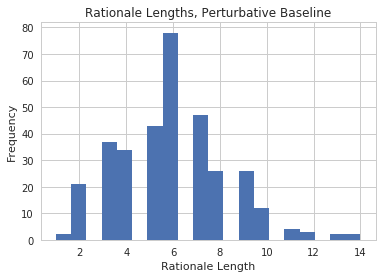

Rationale Lengths, Perturbative Baseline (as percentage of input length):
Mean:  5.702015806549279
Median:  5.113636363636364
Stdev:  3.2698388301002086
Min:  0.7246376811594203
Max:  18.30985915492958


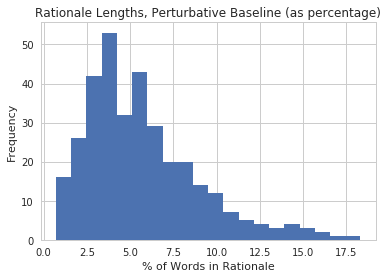

In [38]:
print('Rationale Lengths, Perturbative Baseline:')
print('Mean: ', np.mean(rationale_len_pert))
print('Median: ', np.median(rationale_len_pert))
print('Stdev: ', np.std(rationale_len_pert))
print('Min: ', np.min(rationale_len_pert))
print('Max: ', np.max(rationale_len_pert))

plt.hist(rationale_len_pert, bins=20)
plt.xlabel('Rationale Length')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Perturbative Baseline')
plt.show()

print('Rationale Lengths, Perturbative Baseline (as percentage of input length):')
print('Mean: ', np.mean(rationale_len_pert_percentage))
print('Median: ', np.median(rationale_len_pert_percentage))
print('Stdev: ', np.std(rationale_len_pert_percentage))
print('Min: ', np.min(rationale_len_pert_percentage))
print('Max: ', np.max(rationale_len_pert_percentage))

plt.hist(rationale_len_pert_percentage, bins=20)
plt.xlabel('% of Words in Rationale')
plt.ylabel('Frequency')
plt.title('Rationale Lengths, Perturbative Baseline (as percentage)')
plt.show()

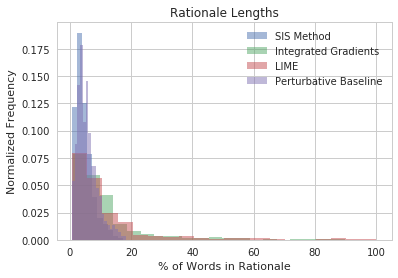

In [55]:
plt.hist(rationale_len_sis_percentage, bins=10, density=True, alpha=0.5, label='SIS Method')
plt.hist(rationale_len_ig_percentage, bins=20, density=True, alpha=0.5, label='Integrated Gradients')
plt.hist(rationale_len_lime_percentage, bins=20, density=True, alpha=0.5, label='LIME')
plt.hist(rationale_len_pert_percentage, bins=20, density=True, alpha=0.5, label='Perturbative Baseline')

plt.xlabel('% of Words in Rationale')
plt.ylabel('Normalized Frequency')
plt.title('Rationale Lengths')
plt.legend(loc='upper right')
plt.show()

In [56]:
# Fixed Length baselines

# IG 
rationale_len_fixed_length_ig_pos = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_fixed_length_ig_neg = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_fixed_length_ig = np.concatenate((rationale_len_fixed_length_ig_pos, rationale_len_fixed_length_ig_neg))

rationale_len_fixed_length_ig_pos_percentage = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_fixed_length_ig_neg_percentage = np.array([len(r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_fixed_length_ig_percentage = np.concatenate((rationale_len_fixed_length_ig_pos_percentage, \
                                                           rationale_len_fixed_length_ig_neg_percentage))

# LIME
rationale_len_fixed_length_lime_pos = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_fixed_length_lime_neg = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_fixed_length_lime = np.concatenate((rationale_len_fixed_length_lime_pos, rationale_len_fixed_length_lime_neg))

rationale_len_fixed_length_lime_pos_percentage = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_fixed_length_lime_neg_percentage = np.array([len(r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_fixed_length_lime_percentage = np.concatenate((rationale_len_fixed_length_lime_pos_percentage, \
                                                             rationale_len_fixed_length_lime_neg_percentage))

# Perturb.
rationale_len_fixed_length_pert_pos = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) for r in brc.get_pos_reviews()])
rationale_len_fixed_length_pert_neg = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) for r in brc.get_neg_reviews()])

rationale_len_fixed_length_pert = np.concatenate((rationale_len_fixed_length_pert_pos, rationale_len_fixed_length_pert_neg))

rationale_len_fixed_length_pert_pos_percentage = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_pos_reviews()])
rationale_len_fixed_length_pert_neg_percentage = np.array([len(r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]) / \
                                                 float(r.get_num_tokens()) * 100.0 \
                                                 for r in brc.get_neg_reviews()])

rationale_len_fixed_length_pert_percentage = np.concatenate((rationale_len_fixed_length_pert_pos_percentage, \
                                                             rationale_len_fixed_length_pert_neg_percentage))

In [57]:
columns = ['method', 'rationale_length']

rationale_len_df = pd.DataFrame.from_dict({'SIS': rationale_len_sis_percentage_allsuffic,
                                           'Suff. IG': rationale_len_ig_percentage,
                                           'Suff. LIME': rationale_len_lime_percentage,
                                           'Suff. Perturb.': rationale_len_pert_percentage,
                                           'IG': rationale_len_fixed_length_ig_percentage,
                                           'LIME': rationale_len_fixed_length_lime_percentage,
                                           'Perturb.': rationale_len_fixed_length_pert_percentage,},
                                          orient='index').transpose()

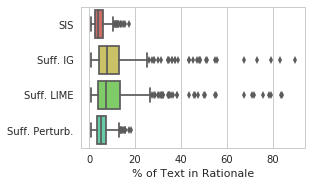

In [2546]:
plt.figure(figsize=(4.5, 2.75))
sns.boxplot(data=rationale_len_df, orient='h', order=['SIS', 'Suff. IG', 'Suff. LIME', 'Suff. Perturb.'], # 'IG', 'LIME', 'Perturb.']
            palette=sns.color_palette('hls', 7))
plt.xlabel('% of Text in Rationale')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'rationale_lengths.png'), dpi=1200, bbox_inches='tight')
plt.show()

In [2326]:
# Dump table rows for paper

stats_baseline = rationale_len_sis_percentage
float_formatter = '%.1f'

for title, vals in [('SIS', rationale_len_sis_percentage), ('Suff. IG', rationale_len_ig_percentage),
                    ('Suff. LIME', rationale_len_lime_percentage), ('Suff. Perturb.', rationale_len_pert_percentage)]:
    vals_median = float_formatter % np.median(vals) + '\%'
    vals_max = float_formatter % np.max(vals) + '\%'
    stat, p = ranksums(stats_baseline, vals)
    if p == 1:
        p = '--'
    else:
        p = '%.0e' % p
    data = [title, vals_median, vals_max, p]
    tex = ' & '.join(data)
    tex += ' &'
    print(tex)

SIS & 3.9\% & 17.3\% & -- &
Suff. IG & 7.7\% & 89.7\% & 5e-26 &
Suff. LIME & 7.2\% & 84.0\% & 4e-23 &
Suff. Perturb. & 5.1\% & 18.3\% & 1e-06 &


## Fraction of rationales in sentence-level annotations

In [2014]:
frac_in_annots_sis_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(SIS_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_sis_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(SIS_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_sis = np.concatenate((frac_in_annots_sis_pos, frac_in_annots_sis_neg))

Mean:  0.49037913411
Median:  0.5
Stdev:  0.290974357633


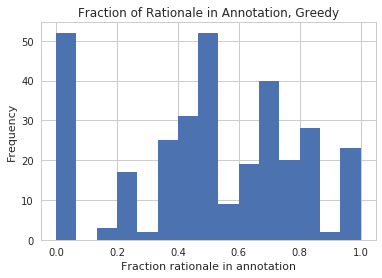

In [2109]:
print('Mean: ', np.mean(frac_in_annots_sis))
print('Median: ', np.median(frac_in_annots_sis))
print('Stdev: ', np.std(frac_in_annots_sis))

plt.hist(frac_in_annots_sis, bins=15)
plt.title('Fraction of Rationale in Annotation, SIS')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_sis_annotonly = np.array([len(r.get_rationales(SIS_RATIONALE_KEY)[0]) / \
                                                float(r.get_num_tokens()) * 100.0 \
                                                for r in brc.get_all_reviews() if r.has_annotation()])

In [798]:
frac_in_annots_ig_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_ig_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_ig = np.concatenate((frac_in_annots_ig_pos, frac_in_annots_ig_neg))

Mean:  0.54241137091
Median:  0.590909090909
Stdev:  0.266366029504


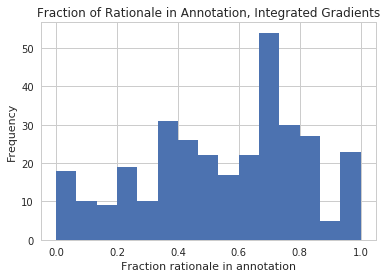

In [2002]:
print('Mean: ', np.mean(frac_in_annots_ig))
print('Median: ', np.median(frac_in_annots_ig))
print('Stdev: ', np.std(frac_in_annots_ig))

plt.hist(frac_in_annots_ig, bins=15)
plt.title('Fraction of Rationale in Annotation, Integrated Gradients')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_ig_annotonly = np.array([len(r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]) / \
                                            float(r.get_num_tokens()) * 100.0 \
                                            for r in brc.get_all_reviews() if r.has_annotation()])

In [1601]:
frac_in_annots_lime_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_lime_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_lime = np.concatenate((frac_in_annots_lime_pos, frac_in_annots_lime_neg))

Mean:  0.552171976497
Median:  0.571428571429
Stdev:  0.25783292568


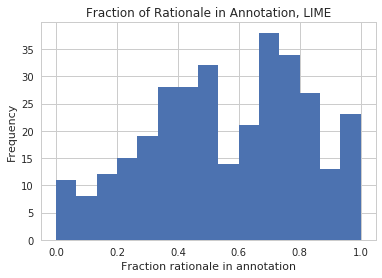

In [2110]:
print('Mean: ', np.mean(frac_in_annots_lime))
print('Median: ', np.median(frac_in_annots_lime))
print('Stdev: ', np.std(frac_in_annots_lime))

plt.hist(frac_in_annots_lime, bins=15)
plt.title('Fraction of Rationale in Annotation, LIME')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_lime_annotonly = np.array([len(r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]) / \
                                            float(r.get_num_tokens()) * 100.0 \
                                            for r in brc.get_all_reviews() if r.has_annotation()])

In [1603]:
frac_in_annots_pert_pos = np.array([r.frac_rationale_in_annotation([r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_pos_reviews() if r.has_annotation()])
frac_in_annots_pert_neg = np.array([r.frac_rationale_in_annotation([r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]]) \
                                          for r in brc.get_neg_reviews() if r.has_annotation()])

frac_in_annots_pert = np.concatenate((frac_in_annots_pert_pos, frac_in_annots_pert_neg))

Mean:  0.630679038883
Median:  0.666666666667
Stdev:  0.254707372778


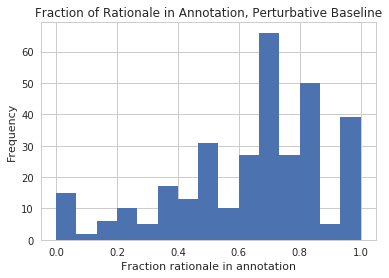

In [2111]:
print('Mean: ', np.mean(frac_in_annots_pert))
print('Median: ', np.median(frac_in_annots_pert))
print('Stdev: ', np.std(frac_in_annots_pert))

plt.hist(frac_in_annots_pert, bins=15)
plt.title('Fraction of Rationale in Annotation, Perturbative Baseline')
plt.xlabel('Fraction rationale in annotation')
plt.ylabel('Frequency')
plt.show()

rationale_lens_pert_annotonly = np.array([len(r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]) / \
                                            float(r.get_num_tokens()) * 100.0 \
                                            for r in brc.get_all_reviews() if r.has_annotation()])

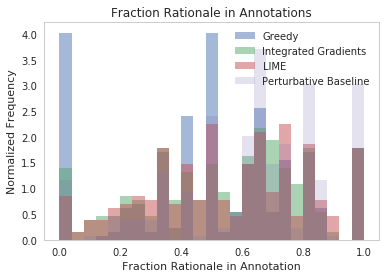

In [2112]:
plt.hist(frac_in_annots_sis, normed=True, bins=25, alpha=0.5, label='SIS')
plt.hist(frac_in_annots_ig, normed=True, bins=25, alpha=0.5, label='Integrated Gradients')
plt.hist(frac_in_annots_lime, normed=True, bins=25, alpha=0.5, label='LIME')
plt.hist(frac_in_annots_pert, normed=True, bins=25, alpha=0.2, label='Perturbative Baseline')

plt.xlabel('Fraction Rationale in Annotation')
plt.ylabel('Normalized Frequency')
plt.title('Fraction Rationale in Annotations')
plt.legend(loc='upper right')
plt.grid(False)
plt.show()

In [2007]:
# Statistical test comparing the distributions

print('SIS vs. Integrated Gradients:')
print(ttest_ind(frac_in_annots_sis, frac_in_annots_ig, equal_var=False))
print(ranksums(frac_in_annots_sis, frac_in_annots_ig))

print('\nSIS vs. LIME:')
print(ttest_ind(frac_in_annots_sis, frac_in_annots_lime, equal_var=False))
print(ranksums(frac_in_annots_sis, frac_in_annots_lime))

print('\nSIS vs. Perturbative Baseline:')
print(ttest_ind(frac_in_annots_sis, frac_in_annots_pert, equal_var=False))
print(ranksums(frac_in_annots_sis, frac_in_annots_pert))

SIS vs. Integrated Gradients:
Ttest_indResult(statistic=-2.3668568842698914, pvalue=0.0182369820355134)
RanksumsResult(statistic=-2.2142126631356724, pvalue=0.026814153170277806)

SIS vs. LIME:
Ttest_indResult(statistic=-2.85213977016104, pvalue=0.0044838908708501385)
RanksumsResult(statistic=-2.4714096020127094, pvalue=0.013458157205171559)

SIS vs. Perturbative Baseline:
Ttest_indResult(statistic=-6.5103424316479446, pvalue=1.5273731171631808e-10)
RanksumsResult(statistic=-6.3696297633039327, pvalue=1.8948504629890169e-10)


## Quality of annotations analysis

In [2008]:
annots_only_preds_pos = np.array([r.prediction_annotation_only for r in brc.get_pos_reviews() \
                                      if r.has_annotation()])
annots_only_preds_neg = np.array([r.prediction_annotation_only for r in brc.get_neg_reviews() \
                                      if r.has_annotation()])

annots_only_preds_pos_deltas = np.array([r.prediction_annotation_only - r.original_prediction \
                                             for r in brc.get_pos_reviews() if r.has_annotation()])
annots_only_preds_neg_deltas = np.array([r.original_prediction - r.prediction_annotation_only \
                                             for r in brc.get_neg_reviews() if r.has_annotation()])

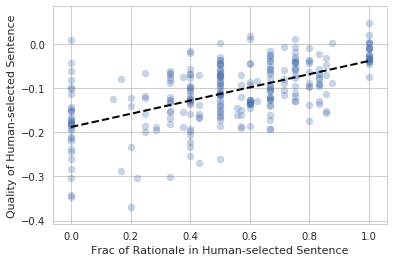

SpearmanrResult(correlation=0.56271001404583321, pvalue=7.2455919557064916e-24)
Pearson r, p: (0.58148565817897013, 9.8668048829682558e-26)
LinregressResult(slope=0.15017439439344654, intercept=-0.18775191337600849, rvalue=0.58148565817897024, pvalue=9.8668048829680021e-26, stderr=0.012858462787597402)


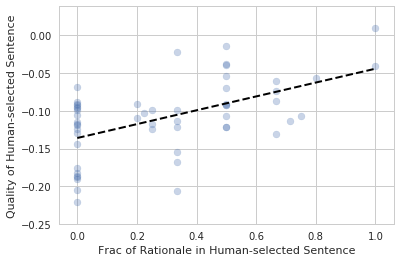

SpearmanrResult(correlation=0.48058634916800957, pvalue=0.00023499806616593166)
Pearson r, p: (0.54262230072135009, 2.2475036253122128e-05)
LinregressResult(slope=0.091721067337397169, intercept=-0.13598213482349253, rvalue=0.5426223007213502, pvalue=2.2475036253122006e-05, stderr=0.019689608689794528)


In [2009]:
plt.scatter(frac_in_annots_sis_pos, annots_only_preds_pos_deltas, alpha=0.3)
plt.plot(np.unique(frac_in_annots_sis_pos),
         np.poly1d(np.polyfit(frac_in_annots_sis_pos,
                              annots_only_preds_pos_deltas, 1))(np.unique(frac_in_annots_sis_pos)),
         '--', c='black', linewidth=2)
plt.xlabel('Frac of Rationale in Human-selected Sentence')
#plt.ylabel('pred on annotation only - original prediction')
plt.ylabel('Quality of Human-selected Sentence')
#plt.title('Effect of Quality of Annotations on Rationale Interpretability, Pos. SIS')
plt.show()

print(spearmanr(frac_in_annots_sis_pos, annots_only_preds_pos_deltas))
print('Pearson r, p:', pearsonr(frac_in_annots_sis_pos, annots_only_preds_pos_deltas))
print(linregress(frac_in_annots_sis_pos, annots_only_preds_pos_deltas))


plt.scatter(frac_in_annots_sis_neg, annots_only_preds_neg_deltas, alpha=0.3)
plt.plot(np.unique(frac_in_annots_sis_neg),
         np.poly1d(np.polyfit(frac_in_annots_sis_neg,
                              annots_only_preds_neg_deltas, 1))(np.unique(frac_in_annots_sis_neg)),
         '--', c='black', linewidth=2)
plt.xlabel('Frac of Rationale in Human-selected Sentence')
#plt.ylabel('original prediction - pred on annotation only')
plt.ylabel('Quality of Human-selected Sentence')
#plt.title('Effect of Quality of Annotations on Rationale Interpretability, Neg. SIS')
plt.show()

print(spearmanr(frac_in_annots_sis_neg, annots_only_preds_neg_deltas))
print('Pearson r, p:', pearsonr(frac_in_annots_sis_neg, annots_only_preds_neg_deltas))
print(linregress(frac_in_annots_sis_neg, annots_only_preds_neg_deltas))

In [2024]:
# For paper, positive and negative examples together,
#   with all sufficient rationales for each example (as independent points)

frac_in_annots_sis_allsuffic = []
quality_of_annotations_allsuffic = []

for review in brc.get_all_reviews():
    if not review.has_annotation():
        continue
    annot_only_pred_delta = review.prediction_annotation_only - review.original_prediction
    if not review.is_pos:  # if negative, want review.original_prediction - review.prediction_annotation_only
        annot_only_pred_delta *= -1
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        frac_in_annots_sis_allsuffic.append(review.frac_rationale_in_annotation([r]))
        quality_of_annotations_allsuffic.append(annot_only_pred_delta)

frac_in_annots_sis_allsuffic = np.array(frac_in_annots_sis_allsuffic)
quality_of_annotations_allsuffic = np.array(quality_of_annotations_allsuffic)

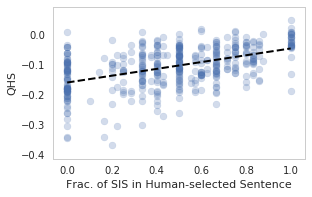

SpearmanrResult(correlation=0.47616121667298078, pvalue=1.5023275117759846e-25)
Pearson r, p: (0.49070687062560464, 2.9514335674583488e-27)
LinregressResult(slope=0.11371658262218201, intercept=-0.15943357077411241, rvalue=0.49070687062560447, pvalue=2.9514335674584819e-27, stderr=0.0097946118793294026)


In [2776]:
# Positive and negative examples together, with all sufficient rationales as separate points (same y value)

plt.figure(figsize=(4.5, 2.9))
plt.scatter(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic, alpha=0.25)
plt.plot(np.unique(frac_in_annots_sis_allsuffic),
         np.poly1d(np.polyfit(frac_in_annots_sis_allsuffic,
                              quality_of_annotations_allsuffic, 1))(np.unique(frac_in_annots_sis_allsuffic)),
         '--', c='black', linewidth=2)
plt.xlabel('Frac. of SIS in Human-selected Sentence')
plt.ylabel('QHS')
#plt.ylabel('Quality of Human-selected Sentence')
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'quality_sentence_vs_frac.png'), dpi=1200, bbox_inches='tight')
plt.show()

print(spearmanr(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic))
print('Pearson r, p:', pearsonr(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic))
print(linregress(frac_in_annots_sis_allsuffic, quality_of_annotations_allsuffic))

In [2328]:
# Highlight examples where the model's decision-making aligned with human annotation and where it didn't

idxs_with_annots_pos = np.array([r.i for r in brc.get_pos_reviews() if r.has_annotation()])
assert(len(idxs_with_annots_pos) == len(frac_in_annots_sis_pos) == len(annots_only_preds_pos_deltas))
upper_right_examples = idxs_with_annots_pos[np.logical_and(
                                              frac_in_annots_sis_pos == 1,
                                              annots_only_preds_pos_deltas >= -0.01)]
# upper_right_reviews = [brc.get_review(i) for i in upper_right_examples]
print('Good example i\'s: ', upper_right_examples)

lower_left_examples = idxs_with_annots_pos[np.logical_and(
                                              frac_in_annots_sis_pos == 0.0,
                                              annots_only_preds_pos_deltas <= -0.3)]
# lower_left_reviews = [brc.get_review(i) for i in upper_right_examples]
print('Misaligned example i\'s: ', lower_left_examples)

Good example i's:  [  5  72 109 118 775 800 862 968]
Misaligned example i's:  [511 924 967]


In [52]:
# Print 5 and 511 for showing with figure in paper.
# Also print quality of annotation score.

html = ''

for i in [5, 511]:
    #html += '<p style="text-align:justify;">'
    review = brc.get_review(i)
    qha = review.prediction_annotation_only - review.original_prediction
    html += visualizations.highlight_multi_rationale(review, review.get_rationales(SIS_RATIONALE_KEY),
                                                     index_to_token)
    print('Example %d:' % i)
    print('QHA: %.5f' % qha)
    print('Orig. Prediction: %.3f' % review.original_prediction)
    print()
    #html += '</p>'
    html += '<br><br><br>'

display(HTML(html))

Example 5:
QHA: 0.00296
Orig. Prediction: 0.900

Example 511:
QHA: -0.30369
Orig. Prediction: 0.928



## Prediction on rationales only vs non-rationales only


In [1631]:
# Positive examples, sis
rationale_only_preds_sis_pos = np.array([r.prediction_rationale_only for r in brc.get_pos_reviews()])
nonrationale_only_preds_sis_pos = np.array([r.prediction_nonrationale_only for r in brc.get_pos_reviews()])

# Negative examples, sis
rationale_only_preds_sis_neg = np.array([r.prediction_rationale_only for r in brc.get_neg_reviews()])
nonrationale_only_preds_sis_neg = np.array([r.prediction_nonrationale_only for r in brc.get_neg_reviews()])

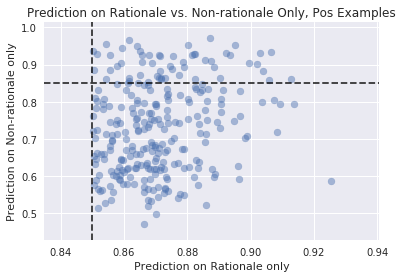

Number of "interesting" non-rationales, positive:  57


In [944]:
plt.scatter(rationale_only_preds_sis_pos, nonrationale_only_preds_sis_pos, alpha=0.45)
plt.axhline(y=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Pos Examples')
plt.show()

nonrationales_interesting_pos_idxs = pos_example_idxs[nonrationale_only_preds_sis_pos >= pos_threshold]
print('Number of "interesting" non-rationales, positive: ', len(nonrationales_interesting_pos_idxs))

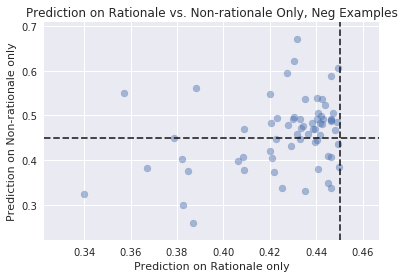

Number of "interesting" non-rationales, negative:  27


In [1643]:
plt.scatter(rationale_only_preds_sis_neg, nonrationale_only_preds_sis_neg, alpha=0.45)
plt.axhline(y=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Neg Examples')
plt.show()

nonrationales_interesting_neg_idxs = neg_example_idxs[nonrationale_only_preds_sis_neg <= neg_threshold]
print('Number of "interesting" non-rationales, negative: ', len(nonrationales_interesting_neg_idxs))

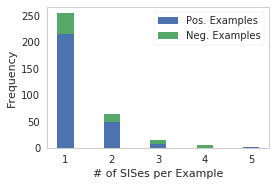

In [2043]:
number_sufficient_rationales_pos = []
for review in brc.get_pos_reviews():
    num_rationales = len(review.get_rationales(SIS_RATIONALE_KEY))
    number_sufficient_rationales_pos.append(num_rationales)

number_sufficient_rationales_neg = []
for review in brc.get_neg_reviews():
    num_rationales = len(review.get_rationales(SIS_RATIONALE_KEY))
    number_sufficient_rationales_neg.append(num_rationales)

num_bins = max(np.max(number_sufficient_rationales_pos), np.max(number_sufficient_rationales_neg))
ind = np.arange(num_bins) + 1
pos_bincounts = np.bincount(number_sufficient_rationales_pos, minlength=num_bins+1)[1:]
neg_bincounts = np.bincount(number_sufficient_rationales_neg, minlength=num_bins+1)[1:]
width = 0.35

plt.figure(figsize=((4, 2.75)))
p_pos = plt.bar(ind, pos_bincounts, width)
p_neg = plt.bar(ind, neg_bincounts, width, bottom=pos_bincounts)
plt.legend((p_pos[0], p_neg[0]), ('Pos. Examples', 'Neg. Examples'), loc='upper right', frameon=True)
plt.xlabel('# of SISes per Example')
plt.ylabel('Frequency')
plt.grid(False)
#plt.title('Num. Sufficient Rationales for Necessary Rationale (Asp 1: Aroma)')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'num_sufficient_rationales.png'), dpi=1200, bbox_inches='tight')
plt.show()

In [21]:
# Show all sufficient examples for some examples

max_sufficient_rationales_pos = 3  # np.max(number_sufficient_rationales_pos)

print('Max # of sufficient rationales: ', max_sufficient_rationales_pos)
print()

palette = sns.color_palette('Dark2')
legend_html = visualizations.make_legend(max_sufficient_rationales_pos, color_palette=palette)
display(HTML(legend_html))

for review in brc.get_pos_reviews():
    num_rationales = len(review.get_rationales(SIS_RATIONALE_KEY))
    if num_rationales == max_sufficient_rationales_pos:
        print('i: ', review.i)
        rationales = review.get_rationales(SIS_RATIONALE_KEY)
        html = visualizations.highlight_multi_rationale(review, review.get_rationales(SIS_RATIONALE_KEY),
                                                        index_to_token)
        display(HTML(html))

Max # of sufficient rationales:  3



i:  7


i:  402


i:  482


i:  556


i:  588


i:  900


i:  918


In [22]:
# Use i=900 as the example in paper

review = brc.get_review(900)
num_rationales = len(review.get_rationales(SIS_RATIONALE_KEY))
html = visualizations.highlight_multi_rationale(review, review.get_rationales(SIS_RATIONALE_KEY),
                                                index_to_token, color_palette=palette)
html += legend_html
display(HTML(html))

#display(HTML(legend_html))

What if we compare the predictions on rationale only vs non-rationale only for the rationales produced by the perturbative baseline to results from sis method above?

Since the perturbation analysis shows that everything in the perturbative rationales matters but they tend to be longer, maybe finding some form of a necessary rationale (rather than sufficient produced by sis method).

In [1636]:
# Positive examples, sis
rationale_only_preds_pert_pos = np.array([sis.predict_for_embed_sequence(
                                            [r.get_embedded_sequence_rationale_only(
                                                [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                            embed_model)[0] for r in brc.get_pos_reviews()])
nonrationale_only_preds_pert_pos = np.array([sis.predict_for_embed_sequence(
                                               [r.get_embedded_sequence_nonrationale_only(
                                                   [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                               embed_model)[0] for r in brc.get_pos_reviews()])

# # Negative examples, sis
rationale_only_preds_pert_neg = np.array([sis.predict_for_embed_sequence(
                                            [r.get_embedded_sequence_rationale_only(
                                                [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                            embed_model)[0] for r in brc.get_neg_reviews()])
nonrationale_only_preds_pert_neg = np.array([sis.predict_for_embed_sequence(
                                               [r.get_embedded_sequence_nonrationale_only(
                                                   [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]])],
                                               embed_model)[0] for r in brc.get_neg_reviews()])

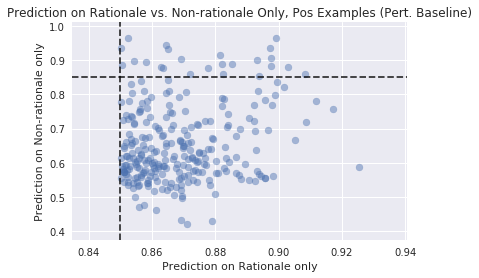

Number of "interesting" non-rationales, positive, perturbative baseline:  24


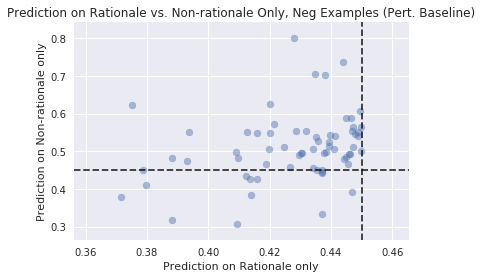

Number of "interesting" non-rationales, negative, perturbative baseline:  14


In [1645]:
plt.scatter(rationale_only_preds_pert_pos, nonrationale_only_preds_pert_pos, alpha=0.45)
plt.axhline(y=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=pos_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Pos Examples (Pert. Baseline)')
plt.show()

print('Number of "interesting" non-rationales, positive, perturbative baseline: ',
          len(pos_example_idxs[nonrationale_only_preds_pert_pos >= pos_threshold]))

plt.scatter(rationale_only_preds_pert_neg, nonrationale_only_preds_pert_neg, alpha=0.45)
plt.axhline(y=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.axvline(x=neg_threshold, linestyle='--', color='black', alpha=0.8)
plt.xlabel('Prediction on Rationale only')
plt.ylabel('Prediction on Non-rationale only')
plt.title('Prediction on Rationale vs. Non-rationale Only, Neg Examples (Pert. Baseline)')
plt.show()

print('Number of "interesting" non-rationales, negative, perturbative baseline: ',
          len(neg_example_idxs[nonrationale_only_preds_pert_neg <= neg_threshold]))

## Integrated Gradients

In [25]:
ig = integrated_gradients(embed_model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [26]:
igs_baseline = np.repeat(mean_embedding.reshape((1, mean_embedding.shape[0])), 500, axis=0)
print(igs_baseline.shape)

(500, 100)


## Dump HTML File with Highlighted Rationales

In [53]:
header = '''
<h2>Beer Review Aspect %d (Aroma) Sufficient Input Subsets</h2>
<p>Each color indices a sufficient input subset (SIS) such that prediction on that subset
    of words (all other words masked out) exceeds the threshold value
    (in positive examples, prediction >= %.2f, in negative examples, prediction <= %.2f).
    Underline indicates known human sentence-level annotations.
    The examples in this set were held-out during training.
    Highlight shade indicates word rank in the rationale, darker means more important,
    with linear scaling.</p>
''' % (ASPECT, pos_threshold, neg_threshold)

# Write all annotations to HTML outfile
html_outfile = '../html_rationales/asp%d_primary_sis.html' % ASPECT
html = ''
first_shown = False
for r in brc.get_all_reviews():
    sis_rationale = r.get_rationales(SIS_RATIONALE_KEY)[0]
    ig_rationale = r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]
    lime_rationale = r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]
    pert_rationale = r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]
    html += '<p>Example %d</p>\n' % (r.i)
    html += '<p>Predicted: %.3f  /  Actual: %.3f<br>\n' % (r.original_prediction, annotations[r.i]['y'][ASPECT])
    html += 'Rationale length SIS = %d<br>\n' % len(sis_rationale)
    html += 'Rationale length Integrated Gradients = %d<br>\n' % len(ig_rationale)
    html += 'Rationale length LIME = %d<br>\n' % len(lime_rationale)
    html += 'Rationale length Perturbative Baseline = %d<br>\n' % len(pert_rationale)
    html += '<p>With SIS Method:</p>\n'
    html += visualizations.highlight_annot(r, sis_rationale, index_to_token, ASPECT)
    html += '\n<p>With Integrated Gradients:</p>\n'
    html += visualizations.highlight_annot(r, ig_rationale, index_to_token, ASPECT)
    html += '\n<p>With LIME:</p>\n'
    html += visualizations.highlight_annot(r, lime_rationale, index_to_token, ASPECT)
    html += '\n<p>With Perturbative Baseline:</p>\n'
    html += visualizations.highlight_annot(r, pert_rationale, index_to_token, ASPECT)
    html += '\n<hr>\n'
    if not first_shown:
        display(HTML(html))
        first_shown = True

# Dump HTML to file
visualizations.save_html(html, html_outfile, header)

In [54]:
# Highlight all rationales in single paragraph (colors no longer aspect-specific)

html_outfile = '../html_rationales/asp%d_multi_sis.html' % ASPECT
html = ''
first_shown = False
most_rationales = None
for r in brc.get_all_reviews():
    sis_rationales = r.get_rationales(SIS_RATIONALE_KEY)
    if most_rationales is None or len(sis_rationales) > most_rationales:
        most_rationales = len(sis_rationales)
    ig_rationale = r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]
    lime_rationale = r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]
    pert_rationale = r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]
    html += '<p>Example %d</p>\n' % (r.i)
    # html += '<p>Predicted: %.3f  /  Actual: %.3f<br>\n' % (r.original_prediction, annotations[r.i]['y'][ASPECT])
    html += 'Rationale length SIS = %s<br>' % str([len(r) for r in sis_rationales])
    html += 'Rationale length Integrated Gradients = %d<br>\n' % len(ig_rationale)
    html += 'Rationale length LIME = %d<br>\n' % len(lime_rationale)
    html += 'Rationale length Perturbative Baseline = %d<br>\n' % len(pert_rationale)
    html += '\n<p><i>With SIS Method:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, sis_rationales, index_to_token)
    html += '\n<p><i>With Integrated Gradients:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, [ig_rationale], index_to_token)
    html += '\n<p><i>With LIME:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, [lime_rationale], index_to_token)
    html += '\n<p><i>With Perturbative Baseline:</i></p>\n'
    html += visualizations.highlight_multi_rationale(r, [pert_rationale], index_to_token)
    html += '\n<hr>\n'
    if not first_shown:
        display(HTML(html))
        first_shown = True

        
legend_html = visualizations.make_legend(most_rationales)

# Dump HTML to file
visualizations.save_html(html, html_outfile, header + legend_html + '<br>')

## History trends over time

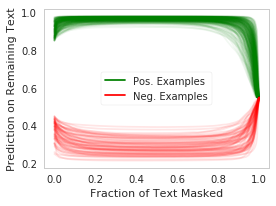

In [2033]:
# SIS

pos_history_data = [(np.linspace(0, 1, len(hist)), np.array(hist)) for hist in \
                    (r.get_rationales(SIS_RATIONALE_KEY)[0].get_history()[1] \
                     for r in brc.get_pos_reviews())]

neg_history_data = [(np.linspace(0, 1, len(hist)), np.array(hist)) for hist in \
                    (r.get_rationales(SIS_RATIONALE_KEY)[0].get_history()[1] \
                     for r in brc.get_neg_reviews())]

plt.figure(figsize=(4, 3))
first = True
for x, y in pos_history_data:
    if first:
        label = 'Pos. Examples'
        first = False
    else:
        label = None
    plt.plot(x, y, alpha=0.05, c='g', label=label)
#plt.title('Predicted Scores during SIS Removal, Positive examples')
plt.xlabel('Fraction of Text Removed')
plt.ylabel('Prediction on Remaining Text')
plt.grid(False)

first = True
for x, y in neg_history_data:
    if first:
        label = 'Neg. Examples'
        first = False
    else:
        label = None
    plt.plot(x, y, alpha=0.1, c='r', label=label)
plt.xlabel('Fraction of Text Masked')
plt.ylabel('Prediction on Remaining Text')
plt.grid(False)
leg = plt.legend(loc='center', frameon=True)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'history_trends.png'), dpi=1200, bbox_inches='tight')
plt.show()

## Perturbation analysis

For all the "interesting" examples, we remove each token one-at-a-time (replacing it with mean embedding) and predict for the sequence with that token missing. Then, see whether the words in the rationales (as found by sis method and IG) lead to bigger losses in predictive power with them removed.

In [1982]:
## (Primary) SIS Rationales

# Positive reviews
rationale_diffs_sis_pos = []
nonrationale_diffs_sis_pos = []

for review in brc.get_pos_reviews():
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        rationale_diffs, nonrationale_diffs = review.perturbation_rationale(
            embed_model,
            [r],
            diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
        rationale_diffs_sis_pos.append(rationale_diffs)
        nonrationale_diffs_sis_pos.append(nonrationale_diffs)

rationale_diffs_sis_pos_vals = np.concatenate(rationale_diffs_sis_pos).ravel()
nonrationale_diffs_sis_pos_vals = np.concatenate(nonrationale_diffs_sis_pos).ravel()

# Negative reviews
rationale_diffs_sis_neg = []
nonrationale_diffs_sis_neg = []

for review in brc.get_neg_reviews():
    for r in review.get_rationales(SIS_RATIONALE_KEY):
        rationale_diffs, nonrationale_diffs = review.perturbation_rationale(
            embed_model,
            [r],
            diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
        rationale_diffs_sis_neg.append(rationale_diffs)
        nonrationale_diffs_sis_neg.append(nonrationale_diffs)
    
rationale_diffs_sis_neg_vals = np.concatenate(rationale_diffs_sis_neg).ravel()
nonrationale_diffs_sis_neg_vals = np.concatenate(nonrationale_diffs_sis_neg).ravel()

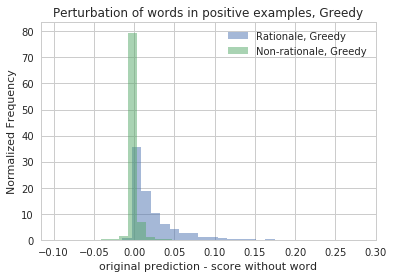

RanksumsResult(statistic=57.869056969761999, pvalue=0.0)


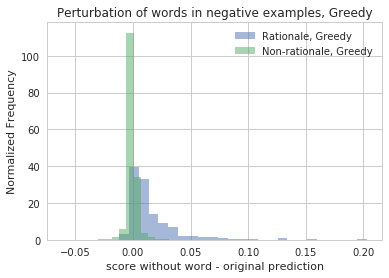

RanksumsResult(statistic=23.597054861303864, pvalue=4.132019188422859e-123)


In [1985]:
plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, SIS')
plt.hist(nonrationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, SIS')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_sis_pos_vals, nonrationale_diffs_sis_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, SIS')
plt.hist(nonrationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, SIS')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, nonrationale_diffs_sis_neg_vals))

In [1619]:
## Integrated Gradients Rationales

# Positive reviews
rationale_diffs_ig_pos = []
nonrationale_diffs_ig_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_ig_pos.append(rationale_diffs)
    nonrationale_diffs_ig_pos.append(nonrationale_diffs)

rationale_diffs_ig_pos_vals = np.concatenate(rationale_diffs_ig_pos).ravel()
nonrationale_diffs_ig_pos_vals = np.concatenate(nonrationale_diffs_ig_pos).ravel()

# Negative reviews
rationale_diffs_ig_neg = []
nonrationale_diffs_ig_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_ig_neg.append(rationale_diffs)
    nonrationale_diffs_ig_neg.append(nonrationale_diffs)
    
rationale_diffs_ig_neg_vals = np.concatenate(rationale_diffs_ig_neg).ravel()
nonrationale_diffs_ig_neg_vals = np.concatenate(nonrationale_diffs_ig_neg).ravel()

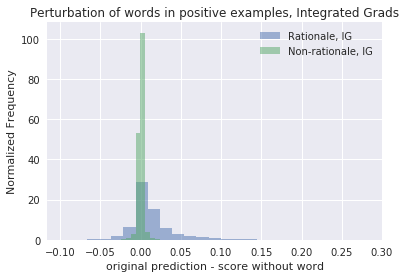

RanksumsResult(statistic=45.894985025039354, pvalue=0.0)


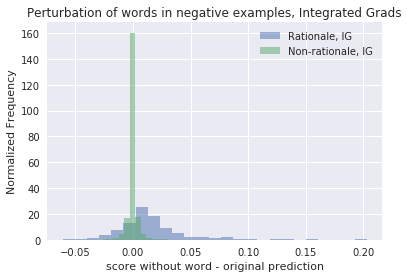

RanksumsResult(statistic=15.090160593474932, pvalue=1.8798421541657925e-51)


In [952]:
plt.hist(rationale_diffs_ig_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, IG')
plt.hist(nonrationale_diffs_ig_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, IG')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, Integrated Grads')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_ig_pos_vals, nonrationale_diffs_ig_pos_vals))

plt.hist(rationale_diffs_ig_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, IG')
plt.hist(nonrationale_diffs_ig_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, IG')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, Integrated Grads')
plt.show()

print(ranksums(rationale_diffs_ig_neg_vals, nonrationale_diffs_ig_neg_vals))

In [1620]:
## LIME Rationales

# Positive reviews
rationale_diffs_lime_pos = []
nonrationale_diffs_lime_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_lime_pos.append(rationale_diffs)
    nonrationale_diffs_lime_pos.append(nonrationale_diffs)

rationale_diffs_lime_pos_vals = np.concatenate(rationale_diffs_lime_pos).ravel()
nonrationale_diffs_lime_pos_vals = np.concatenate(nonrationale_diffs_lime_pos).ravel()

# Negative reviews
rationale_diffs_lime_neg = []
nonrationale_diffs_lime_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_lime_neg.append(rationale_diffs)
    nonrationale_diffs_lime_neg.append(nonrationale_diffs)
    
rationale_diffs_lime_neg_vals = np.concatenate(rationale_diffs_lime_neg).ravel()
nonrationale_diffs_lime_neg_vals = np.concatenate(nonrationale_diffs_lime_neg).ravel()

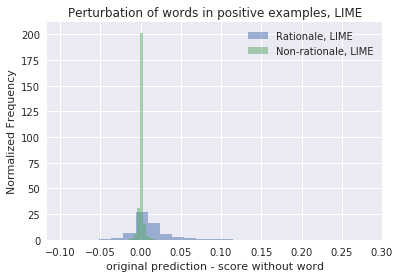

RanksumsResult(statistic=45.671905220097486, pvalue=0.0)


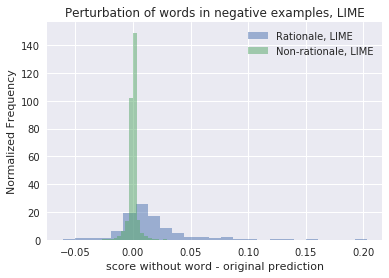

RanksumsResult(statistic=16.140783676172965, pvalue=1.3185646170395768e-58)


In [1624]:
plt.hist(rationale_diffs_lime_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, LIME')
plt.hist(nonrationale_diffs_lime_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, LIME')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, LIME')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_lime_pos_vals, nonrationale_diffs_lime_pos_vals))

plt.hist(rationale_diffs_lime_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, LIME')
plt.hist(nonrationale_diffs_lime_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, LIME')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, LIME')
plt.show()

print(ranksums(rationale_diffs_lime_neg_vals, nonrationale_diffs_lime_neg_vals))

In [1790]:
## Perturbative Baseline Rationales

# Positive reviews
rationale_diffs_pert_pos = []
nonrationale_diffs_pert_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_pert_pos.append(rationale_diffs)
    nonrationale_diffs_pert_pos.append(nonrationale_diffs)

rationale_diffs_pert_pos_vals = np.concatenate(rationale_diffs_pert_pos).ravel()
nonrationale_diffs_pert_pos_vals = np.concatenate(nonrationale_diffs_pert_pos).ravel()

# Negative reviews
rationale_diffs_pert_neg = []
nonrationale_diffs_pert_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_SUFF_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_pert_neg.append(rationale_diffs)
    nonrationale_diffs_pert_neg.append(nonrationale_diffs)
    
rationale_diffs_pert_neg_vals = np.concatenate(rationale_diffs_pert_neg).ravel()
nonrationale_diffs_pert_neg_vals = np.concatenate(nonrationale_diffs_pert_neg).ravel()

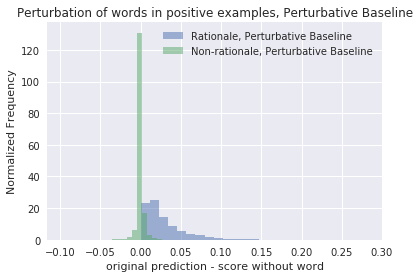

RanksumsResult(statistic=68.275431225436975, pvalue=0.0)


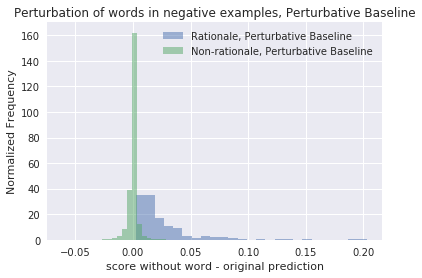

RanksumsResult(statistic=27.850422629911428, pvalue=1.0645166686250175e-170)


In [1791]:
plt.hist(rationale_diffs_pert_pos_vals, normed=True, alpha=0.5, bins=25, label='Rationale, Perturbative Baseline')
plt.hist(nonrationale_diffs_pert_pos_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, Perturbative Baseline')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, Perturbative Baseline')
plt.show()

# Compare the two distributions using ranksum test
print(ranksums(rationale_diffs_pert_pos_vals, nonrationale_diffs_pert_pos_vals))

plt.hist(rationale_diffs_pert_neg_vals, normed=True, alpha=0.5, bins=25, label='Rationale, Perturbative Baseline')
plt.hist(nonrationale_diffs_pert_neg_vals, normed=True, alpha=0.5, bins=25, label='Non-rationale, Perturbative Baseline')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, Perturbative Baseline')
plt.show()

print(ranksums(rationale_diffs_pert_neg_vals, nonrationale_diffs_pert_neg_vals))

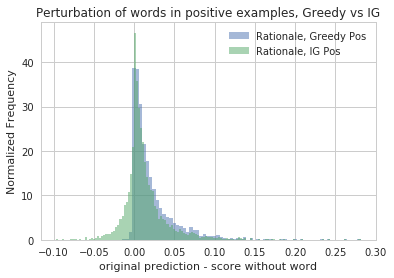

RanksumsResult(statistic=14.446201104255175, pvalue=2.6489881071598993e-47)


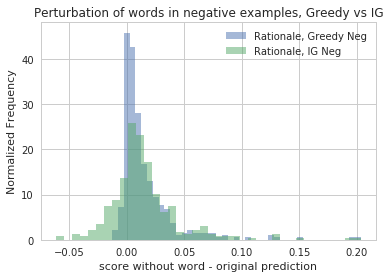

RanksumsResult(statistic=0.058853080552167682, pvalue=0.95306912952702894)


In [1986]:
# Compare rationales-only to rationales-only

plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Pos')
plt.hist(rationale_diffs_ig_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, IG Pos')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS vs IG')
plt.show()

print(ranksums(rationale_diffs_sis_pos_vals, rationale_diffs_ig_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Neg')
plt.hist(rationale_diffs_ig_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, IG Neg')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS vs IG')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, rationale_diffs_ig_neg_vals))

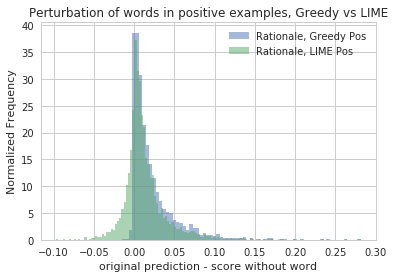

RanksumsResult(statistic=13.068767544832388, pvalue=4.9663628549357408e-39)


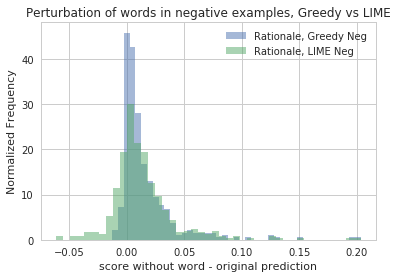

RanksumsResult(statistic=1.0987427997391532, pvalue=0.2718802683100433)


In [1987]:
plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Pos')
plt.hist(rationale_diffs_lime_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, LIME Pos')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS vs LIME')
plt.show()

print(ranksums(rationale_diffs_sis_pos_vals, rationale_diffs_lime_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Neg')
plt.hist(rationale_diffs_lime_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, LIME Neg')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS vs LIME')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, rationale_diffs_lime_neg_vals))

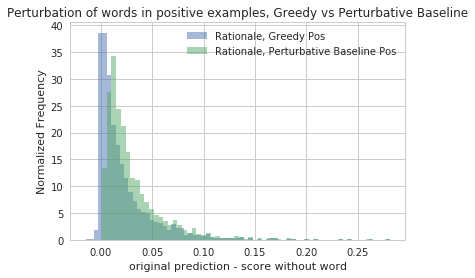

RanksumsResult(statistic=-15.793588127567098, pvalue=3.4441847422647934e-56)


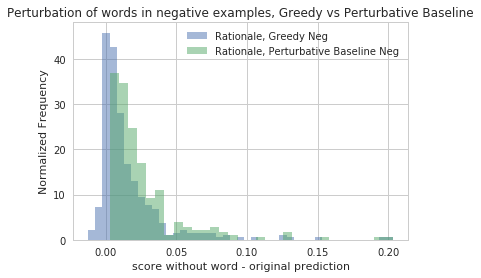

RanksumsResult(statistic=-8.3843969519022625, pvalue=5.0986463640918175e-17)


In [1988]:
plt.hist(rationale_diffs_sis_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Pos')
plt.hist(rationale_diffs_pert_pos_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, Perturbative Baseline Pos')
plt.legend(loc='upper right')
plt.xlabel('original prediction - score without word')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in positive examples, SIS vs Perturbative Baseline')
plt.show()

print(ranksums(rationale_diffs_sis_pos_vals, rationale_diffs_pert_pos_vals))

plt.hist(rationale_diffs_sis_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, SIS Neg')
plt.hist(rationale_diffs_pert_neg_vals, normed=True, alpha=0.5, bins='auto', label='Rationale, Perturbative Baseline Neg')
plt.legend(loc='upper right')
plt.xlabel('score without word - original prediction')
plt.ylabel('Normalized Frequency')
plt.title('Perturbation of words in negative examples, SIS vs Perturbative Baseline')
plt.show()

print(ranksums(rationale_diffs_sis_neg_vals, rationale_diffs_pert_neg_vals))

In [2393]:
## Fixed Length IG Baseline Rationales

# Positive reviews
rationale_diffs_fixed_length_ig_pos = []
nonrationale_diffs_fixed_length_ig_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_fixed_length_ig_pos.append(rationale_diffs)
    nonrationale_diffs_fixed_length_ig_pos.append(nonrationale_diffs)

rationale_diffs_fixed_length_ig_pos_vals = np.concatenate(rationale_diffs_fixed_length_ig_pos).ravel()
nonrationale_diffs_fixed_length_ig_pos_vals = np.concatenate(nonrationale_diffs_fixed_length_ig_pos).ravel()

# Negative reviews
rationale_diffs_fixed_length_ig_neg = []
nonrationale_diffs_fixed_length_ig_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(IG_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_fixed_length_ig_neg.append(rationale_diffs)
    nonrationale_diffs_fixed_length_ig_neg.append(nonrationale_diffs)
    
rationale_diffs_fixed_length_ig_neg_vals = np.concatenate(rationale_diffs_fixed_length_ig_neg).ravel()
nonrationale_diffs_fixed_length_ig_neg_vals = np.concatenate(nonrationale_diffs_fixed_length_ig_neg).ravel()

In [2394]:
## Fixed Length LIME Baseline Rationales

# Positive reviews
rationale_diffs_fixed_length_lime_pos = []
nonrationale_diffs_fixed_length_lime_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_fixed_length_lime_pos.append(rationale_diffs)
    nonrationale_diffs_fixed_length_lime_pos.append(nonrationale_diffs)

rationale_diffs_fixed_length_lime_pos_vals = np.concatenate(rationale_diffs_fixed_length_lime_pos).ravel()
nonrationale_diffs_fixed_length_lime_pos_vals = np.concatenate(nonrationale_diffs_fixed_length_lime_pos).ravel()

# Negative reviews
rationale_diffs_fixed_length_lime_neg = []
nonrationale_diffs_fixed_length_lime_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(LIME_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_fixed_length_lime_neg.append(rationale_diffs)
    nonrationale_diffs_fixed_length_lime_neg.append(nonrationale_diffs)
    
rationale_diffs_fixed_length_lime_neg_vals = np.concatenate(rationale_diffs_fixed_length_lime_neg).ravel()
nonrationale_diffs_fixed_length_lime_neg_vals = np.concatenate(nonrationale_diffs_fixed_length_lime_neg).ravel()

In [2392]:
## Fixed Length Perturbative Baseline Rationales

# Positive reviews
rationale_diffs_fixed_length_pert_pos = []
nonrationale_diffs_fixed_length_pert_pos = []

for r in brc.get_pos_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[1] - preds_orig[0])
    rationale_diffs_fixed_length_pert_pos.append(rationale_diffs)
    nonrationale_diffs_fixed_length_pert_pos.append(nonrationale_diffs)

rationale_diffs_fixed_length_pert_pos_vals = np.concatenate(rationale_diffs_fixed_length_pert_pos).ravel()
nonrationale_diffs_fixed_length_pert_pos_vals = np.concatenate(nonrationale_diffs_fixed_length_pert_pos).ravel()

# Negative reviews
rationale_diffs_fixed_length_pert_neg = []
nonrationale_diffs_fixed_length_pert_neg = []

for r in brc.get_neg_reviews():
    rationale_diffs, nonrationale_diffs = r.perturbation_rationale(
        embed_model,
        [r.get_rationales(PERTURB_FIXED_RATIONALE_KEY)[0]],
        diffs_transform_f=lambda preds_orig: preds_orig[0] - preds_orig[1])
    rationale_diffs_fixed_length_pert_neg.append(rationale_diffs)
    nonrationale_diffs_fixed_length_pert_neg.append(nonrationale_diffs)
    
rationale_diffs_fixed_length_pert_neg_vals = np.concatenate(rationale_diffs_fixed_length_pert_neg).ravel()
nonrationale_diffs_fixed_length_pert_neg_vals = np.concatenate(nonrationale_diffs_fixed_length_pert_neg).ravel()

In [2541]:
# Merge results from positive and negative examples
rationale_diffs_sis_all_vals = np.concatenate((rationale_diffs_sis_pos_vals, rationale_diffs_sis_neg_vals))
rationale_diffs_ig_all_vals = np.concatenate((rationale_diffs_ig_pos_vals, rationale_diffs_ig_neg_vals))
rationale_diffs_lime_all_vals = np.concatenate((rationale_diffs_lime_pos_vals, rationale_diffs_lime_neg_vals))
rationale_diffs_pert_all_vals = np.concatenate((rationale_diffs_pert_pos_vals, rationale_diffs_pert_neg_vals))
rationale_diffs_fixed_length_ig_all_vals = np.concatenate((rationale_diffs_fixed_length_ig_pos_vals, rationale_diffs_fixed_length_ig_neg_vals))
rationale_diffs_fixed_length_lime_all_vals = np.concatenate((rationale_diffs_fixed_length_lime_pos_vals, rationale_diffs_fixed_length_lime_neg_vals))
rationale_diffs_fixed_length_pert_all_vals = np.concatenate((rationale_diffs_fixed_length_pert_pos_vals, rationale_diffs_fixed_length_pert_neg_vals))

nonrationale_diffs_sis_all_vals = np.concatenate((nonrationale_diffs_sis_pos_vals, nonrationale_diffs_sis_neg_vals))
nonrationale_diffs_ig_all_vals = np.concatenate((nonrationale_diffs_ig_pos_vals, nonrationale_diffs_ig_neg_vals))
nonrationale_diffs_lime_all_vals = np.concatenate((nonrationale_diffs_lime_pos_vals, nonrationale_diffs_lime_neg_vals))
nonrationale_diffs_pert_all_vals = np.concatenate((nonrationale_diffs_pert_pos_vals, nonrationale_diffs_pert_neg_vals))
nonrationale_diffs_fixed_length_ig_all_vals = np.concatenate((nonrationale_diffs_fixed_length_ig_pos_vals, nonrationale_diffs_fixed_length_ig_neg_vals))
nonrationale_diffs_fixed_length_lime_all_vals = np.concatenate((nonrationale_diffs_fixed_length_lime_pos_vals, nonrationale_diffs_fixed_length_lime_neg_vals))
nonrationale_diffs_fixed_length_pert_all_vals = np.concatenate((nonrationale_diffs_fixed_length_pert_pos_vals, nonrationale_diffs_fixed_length_pert_neg_vals))


# Create DataFrame
columns = ['method', 'rationale_nonrationale', 'perturbation_delta']

sis_rationale_df = pd.DataFrame([('SIS', 'Rationale', p) for p in rationale_diffs_sis_all_vals],
                                   columns=columns)
sis_nonrationale_df = pd.DataFrame([('SIS', 'Other text', p) for p in nonrationale_diffs_sis_all_vals],
                                   columns=columns)

ig_rationale_df = pd.DataFrame([('Suff. IG', 'Rationale', p) for p in rationale_diffs_ig_all_vals],
                                   columns=columns)
ig_nonrationale_df = pd.DataFrame([('Suff. IG', 'Other text', p) for p in nonrationale_diffs_ig_all_vals],
                                   columns=columns)

lime_rationale_df = pd.DataFrame([('Suff. LIME', 'Rationale', p) for p in rationale_diffs_lime_all_vals],
                                   columns=columns)
lime_nonrationale_df = pd.DataFrame([('Suff. LIME', 'Other text', p) for p in nonrationale_diffs_lime_all_vals],
                                   columns=columns)

pert_rationale_df = pd.DataFrame([('Suff. Perturb.', 'Rationale', p) for p in rationale_diffs_pert_all_vals],
                                   columns=columns)
pert_nonrationale_df = pd.DataFrame([('Suff. Perturb.', 'Other text', p) for p in nonrationale_diffs_pert_all_vals],
                                   columns=columns)

fixed_length_ig_rationale_df = pd.DataFrame([('IG', 'Rationale', p) for p in rationale_diffs_fixed_length_ig_all_vals],
                                   columns=columns)
fixed_length_ig_nonrationale_df = pd.DataFrame([('IG', 'Other text', p) for p in nonrationale_diffs_fixed_length_ig_all_vals],
                                   columns=columns)

fixed_length_lime_rationale_df = pd.DataFrame([('LIME', 'Rationale', p) for p in rationale_diffs_fixed_length_lime_all_vals],
                                   columns=columns)
fixed_length_lime_nonrationale_df = pd.DataFrame([('LIME', 'Other text', p) for p in nonrationale_diffs_fixed_length_lime_all_vals],
                                   columns=columns)

fixed_length_pert_rationale_df = pd.DataFrame([('Perturb.', 'Rationale', p) for p in rationale_diffs_fixed_length_pert_all_vals],
                                   columns=columns)
fixed_length_pert_nonrationale_df = pd.DataFrame([('Perturb.', 'Other text', p) for p in nonrationale_diffs_fixed_length_pert_all_vals],
                                   columns=columns)

perturbation_df = pd.concat([sis_rationale_df, sis_nonrationale_df,
                             ig_rationale_df, ig_nonrationale_df,
                             lime_rationale_df, lime_nonrationale_df,
                             pert_rationale_df, pert_nonrationale_df],
#                              fixed_length_ig_rationale_df, fixed_length_ig_nonrationale_df,
#                              fixed_length_lime_rationale_df, fixed_length_lime_nonrationale_df,
#                              fixed_length_pert_rationale_df, fixed_length_pert_nonrationale_df],
                            ignore_index=True)

In [2542]:
# Statistical analysis
print('Median SIS R: ', np.median(rationale_diffs_sis_all_vals))
print('Median SIS NR: ', np.median(nonrationale_diffs_sis_all_vals))
print('Median IG R: ', np.median(rationale_diffs_ig_all_vals))
print('Median IG NR: ', np.median(nonrationale_diffs_ig_all_vals))
print('Median LIME R: ', np.median(rationale_diffs_lime_all_vals))
print('Median LIME NR: ', np.median(nonrationale_diffs_lime_all_vals))
print('Median Perturb R: ', np.median(rationale_diffs_pert_all_vals))
print('Median Perturb NR: ', np.median(nonrationale_diffs_pert_all_vals))
print()
print('SIS R vs. NR: ', ranksums(rationale_diffs_sis_all_vals, nonrationale_diffs_sis_all_vals))
print('IG R vs. NR: ', ranksums(rationale_diffs_ig_all_vals, nonrationale_diffs_ig_all_vals))
print('LIME R vs. NR: ', ranksums(rationale_diffs_lime_all_vals, nonrationale_diffs_lime_all_vals))
print('Perturb R vs. NR: ', ranksums(rationale_diffs_pert_all_vals, nonrationale_diffs_pert_all_vals))
print()
print('SIS R vs. IG R: ', ranksums(rationale_diffs_sis_all_vals, rationale_diffs_ig_all_vals))
print('SIS R vs. LIME R: ', ranksums(rationale_diffs_sis_all_vals, rationale_diffs_lime_all_vals))
print('SIS R vs. Perturb R: ', ranksums(rationale_diffs_sis_all_vals, rationale_diffs_pert_all_vals))

Median SIS R:  0.0112366
Median SIS NR:  1.50204e-05
Median IG R:  0.00679982
Median IG NR:  1.85072e-05
Median LIME R:  0.0074634
Median LIME NR:  1.87159e-05
Median Perturb R:  0.0208704
Median Perturb NR:  1.89543e-05

SIS R vs. NR:  RanksumsResult(statistic=62.45331746432516, pvalue=0.0)
IG R vs. NR:  RanksumsResult(statistic=48.576959393408011, pvalue=0.0)
LIME R vs. NR:  RanksumsResult(statistic=48.661609814264352, pvalue=0.0)
Perturb R vs. NR:  RanksumsResult(statistic=73.764513127877549, pvalue=0.0)

SIS R vs. IG R:  RanksumsResult(statistic=13.630259455185415, pvalue=2.646377825293114e-42)
SIS R vs. LIME R:  RanksumsResult(statistic=12.463926118976861, pvalue=1.1744318923988504e-35)
SIS R vs. Perturb R:  RanksumsResult(statistic=-18.035017738731497, pvalue=1.034622329136899e-72)


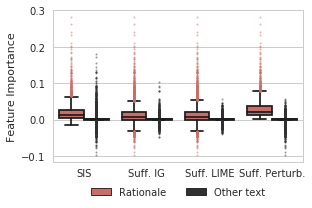

In [2545]:
# https://stackoverflow.com/questions/36874697/how-to-edit-properties-of-whiskers-fliers-caps-etc-in-seaborn-boxplot
#   for boxplot drawing

plt.figure(figsize=(4.5, 2.75))
ax = sns.boxplot(x='method', y='perturbation_delta', hue='rationale_nonrationale',
            data=perturbation_df, orient='v',
            palette=sns.color_palette([sns.color_palette('hls', 8)[0], sns.light_palette('black', reverse=True)[1]]),
            flierprops={'markersize': 2, 'marker': 'o', 'alpha': 0.5})
for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    for j in range(i*6, i*6+6):
        line = ax.lines[j]
        line.set_mfc(col)
        line.set_mec(col)
plt.xlabel('')
plt.ylabel('Feature Importance')
plt.legend(loc='center', title=None, frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'perturbation_boxplot.png'), dpi=1200, bbox_inches='tight')
plt.show()

In [2768]:
# Dump table rows for paper

rats_baseline = rationale_diffs_sis_all_vals
float_formatter = '%.4f'
exp_formatter = '%.2e'

for title, rat_vals, other_vals in [('SIS', rationale_diffs_sis_all_vals, nonrationale_diffs_sis_all_vals),
                    ('Suff. IG', rationale_diffs_ig_all_vals, nonrationale_diffs_ig_all_vals),
                    ('Suff. LIME', rationale_diffs_lime_all_vals, nonrationale_diffs_lime_all_vals),
                    ('Suff. Perturb.', rationale_diffs_pert_all_vals, nonrationale_diffs_pert_all_vals)]:
    median_rationales = float_formatter % np.median(rat_vals)
    median_other = exp_formatter % np.median(other_vals)
    _, p_rat = ranksums(rats_baseline, rat_vals)
    if p_rat == 1:
        p_rat = '--'
    else:
        p_rat = '%.0e' % p_rat
    data = [median_rationales, median_other, p_rat]
    tex = ' & '.join(data)
    tex += '  \\\\'
    print(tex)

0.0112 & 1.50e-05 & --  \\
0.0068 & 1.85e-05 & 3e-42  \\
0.0075 & 1.87e-05 & 1e-35  \\
0.0209 & 1.90e-05 & 1e-72  \\


# Rationale-only Prediction vs. Rationale Length

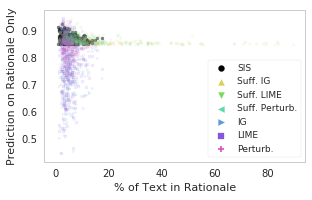

In [2777]:
keys = [(SIS_RATIONALE_KEY, 'SIS'), (IG_SUFF_RATIONALE_KEY, 'Suff. IG'), (LIME_SUFF_RATIONALE_KEY, 'Suff. LIME'),
        (PERTURB_SUFF_RATIONALE_KEY, 'Suff. Perturb.'), (IG_FIXED_RATIONALE_KEY, 'IG'),
        (LIME_FIXED_RATIONALE_KEY, 'LIME'), (PERTURB_FIXED_RATIONALE_KEY, 'Perturb.')]

markers = ['o', '^', 'v', '<', '>', 's', '+']

#plt.figure(figsize=(4.25, 3.0))
plt.figure(figsize=(4.5, 2.9))
for i, (rationale_key, label) in enumerate(keys):
    x_rationale_only = []
    rationale_lens_percentage = []
    for review in brc.get_pos_reviews():
        rationales = review.get_rationales(rationale_key)
        for rationale in rationales:
            x_rationale_only.append(review.get_embedded_sequence_rationale_only([rationale]))
            rationale_lens_percentage.append(len(rationale) / float(review.get_num_tokens()) * 100.0)
    rationale_only_preds = sis.predict_for_embed_sequence(x_rationale_only, embed_model)
    rationale_lens_percentage = np.array(rationale_lens_percentage)
    assert(rationale_only_preds.shape == rationale_lens_percentage.shape)

    if i == 0:
        color = 'black'
        alpha = 0.5
    else:
        color = sns.color_palette('hls', 7)[i]
        alpha = 0.10
    marker = markers[i]

    plt.scatter(rationale_lens_percentage, rationale_only_preds, c=color, alpha=alpha, s=9, label=label, marker=marker)

plt.xlabel('% of Text in Rationale')
plt.ylabel('Prediction on Rationale Only')
plt.grid(False)
leg = plt.legend(loc='lower right', frameon=True, markerscale=2, fontsize=9)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'rationale_prediction_vs_length_pos.png'), dpi=1200, bbox_inches='tight')
plt.show()

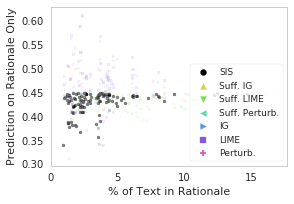

In [2540]:
plt.figure(figsize=(4.25, 3.0))
for i, (rationale_key, label) in enumerate(keys):
    x_rationale_only = []
    rationale_lens_percentage = []
    for review in brc.get_neg_reviews():
        rationales = review.get_rationales(rationale_key)
        for rationale in rationales:
            x_rationale_only.append(review.get_embedded_sequence_rationale_only([rationale]))
            rationale_lens_percentage.append(len(rationale) / float(review.get_num_tokens()) * 100.0)
    rationale_only_preds = sis.predict_for_embed_sequence(x_rationale_only, embed_model)
    rationale_lens_percentage = np.array(rationale_lens_percentage)
    assert(rationale_only_preds.shape == rationale_lens_percentage.shape)

    if i == 0:
        color = 'black'
        alpha = 0.5
    else:
        color = sns.color_palette('hls', 7)[i]
        alpha = 0.10
    marker = markers[i]

    plt.scatter(rationale_lens_percentage, rationale_only_preds, c=color, alpha=alpha, s=9, label=label, marker=marker)

plt.xlabel('% of Text in Rationale')
plt.ylabel('Prediction on Rationale Only')
plt.grid(False)
leg = plt.legend(loc='lower right', frameon=True, markerscale=2, fontsize=9)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'rationale_prediction_vs_length_neg.png'), dpi=1200, bbox_inches='tight')
plt.show()

## How well can we approximate ordering at first iteration?

What fraction rationale is found in the top `k` most important words as determined by the perturbations at the first sis iteration? If the fraction is large for small `k`, we can effectively shortcut to the final words initially and get a good, much-faster approximation to the rationale.

In [1191]:
%%time

fracs_initial = []

for review in brc.get_pos_reviews():
    k = 20
    x_embed = review.get_embedded_sequence()
    preds = sis.removed_word_predictions(x_embed, embed_model, review.num_pad, mean_embedding)
    top_elms_initial = preds.argsort()[:k]
    rationale_elms = review.get_rationales(SIS_RATIONALE_KEY)[0].get_elms()
    frac_initial = np.intersect1d(top_elms_initial, rationale_elms).shape[0] / float(len(rationale_elms))
    fracs_initial.append(frac_initial)

CPU times: user 2min 55s, sys: 2.93 s, total: 2min 57s
Wall time: 2min 54s


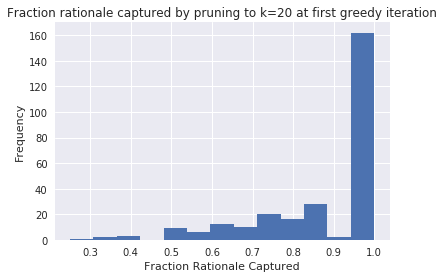

In [1195]:
plt.hist(fracs_initial, bins='auto')
plt.xlabel('Fraction Rationale Captured')
plt.ylabel('Frequency')
plt.title('Fraction rationale captured by pruning to k=%d at first sis iteration' % k)
plt.show()

## Clustering of all sufficient rationales

Clustering examples with strong predicted positive sentiment:

In [73]:
# Clustering reviews from X_test (in brc_test)

all_sis_tokenized = clustering.text_get_all_sis_tokenized(brc_test.get_pos_reviews())
dist_matrix = clustering.compute_jaccard_dist_matrix(all_sis_tokenized)

print('Dist Matrix Median: ', np.median(dist_matrix[dist_matrix != 1.0]))

Dist Matrix Median:  0.8888888888888888


In [74]:
cluster_to_core_idxs, cluster_to_noncore_idxs, labels = clustering.cluster(
    dist_matrix,
    eps=0.5,
    min_samples=10,
    verbose=True,
)

cluster_label_to_cluster = clustering.get_label_to_cluster(labels)

Estimated number of clusters: 7
# core samples:  51


In [75]:
# Print clusters

clustering.text_print_clustering_by_freq(cluster_label_to_cluster,
                                         cluster_to_core_idxs,
                                         all_sis_tokenized,
                                         brc_test.index_to_token,
                                         num_top=10)

-- Cluster -1 --
chai chai	2
smells heavenly	2
hopslam hopslam	2
pb j	2
intoxicating incredible	2
harpoon interesting nice great misleading	1
nose dominated citrus piney hops excellent flavor	1
fruity nose apricots clove aroma honey perfect	1
perfect huge great magnificent	1
huge honey nice floral hops t	1

-- Cluster 0 --
smell amazing wonderful	2
nice wonderful nose	2
wonderful amazing	2
amazing amazing	2
wonderful wonderful	2
cambridge amazing	1
great wonderful wonderful	1
huge aroma starbucks	1
amazing intoxicating	1
amazing huge banana	1

-- Cluster 1 --
grapefruit mango pineapple	2
pineapple grapefruit pineapple grapefruit	1
hops grapefruit pineapple floyds	1
mango pineapple incredible	1
mango tangerine pineapple	1
mango grapefruit peach	1
grapefruit peach pineapple great	1
tangerine pineapple mango pineapple	1
mango grapefruit pineapple begs	1
pineapple mango pineapple expecting	1

-- Cluster 2 --
nice smell citrus nice grapefruit taste	1
smell great complex ripe taste	1
nice sm

In [76]:
df = clustering.latex_table_text_clusters(cluster_label_to_cluster,
                                          cluster_to_core_idxs,
                                          all_sis_tokenized,
                                          brc_test.index_to_token,
                                          num_sis=4,
                                          show_noise_cluster=False,
                                          include_freq=True)
df

,SIS 1,SIS 1 Freq,SIS 2,SIS 2 Freq,SIS 3,SIS 3 Freq,SIS 4,SIS 4 Freq
$C_{1}$,smell amazing wonderful,2,nice wonderful nose,2,wonderful amazing,2,amazing amazing,2
$C_{2}$,grapefruit mango pineapple,2,pineapple grapefruit pineapple grapefruit,1,hops grapefruit pineapple floyds,1,mango pineapple incredible,1
$C_{3}$,nice smell citrus nice grapefruit taste,1,smell great complex ripe taste,1,nice smell nice hop smell pine taste,1,love nice nice smell bliss taste,1
$C_{4}$,fresh great fantastic taste,1,rich great fantastic hoped,1,fantastic cherries fantastic,1,everyone great snifters fantastic,1
$C_{5}$,awesome bounds,1,awesome grapefruit awesome,1,awesome awesome pleasing,1,awesome nailed nailed,1
$C_{6}$,creme brulee brulee,3,creme brulee decadent,1,incredible creme brulee,1,creme brulee exceptional,1
$C_{7}$,oak vanilla chocolate cinnamon vanilla oak love,1,dose oak chocolate vanilla acidic,1,vanilla figs oak thinner great,1,chocolate aroma oak vanilla dessert,1


In [80]:
latex_table = clustering.clean_latex_table_output(
    df.to_latex(escape=False), make_figure=True, clean_freq_cols=True)
print(latex_table)

\begin{figure}
    \begingroup  % for font size
    \footnotesize
    \begin{tabularx}{\textwidth}{XXXXXXXXX}
Cluster &                                            SIS 1 &  Freq. &                                      SIS 2 &  Freq. &                                 SIS 3 &  Freq. &                                SIS 4 &  Freq. \\
\midrule
$C_{1}$ &                          smell amazing wonderful &           2 &                        nice wonderful nose &           2 &                     wonderful amazing &           2 &                      amazing amazing &           2 \\
$C_{2}$ &                       grapefruit mango pineapple &           2 &  pineapple grapefruit pineapple grapefruit &           1 &      hops grapefruit pineapple floyds &           1 &           mango pineapple incredible &           1 \\
$C_{3}$ &          nice smell citrus nice grapefruit taste &           1 &             smell great complex ripe taste &           1 &  nice smell nice hop smell pine taste &  

In [89]:
# Abbreviated version of table for maintext (show C1, C2, C6)

df_maintext = df.iloc[[0, 1, 5]]

In [90]:
latex_table_maintext = clustering.clean_latex_table_output(
    df_maintext.to_latex(escape=False), make_figure=True, clean_freq_cols=True)
print(latex_table_maintext)

\begin{figure}
    \begingroup  % for font size
    \footnotesize
    \begin{tabularx}{\textwidth}{XXXXXXXXX}
Cluster &                       SIS 1 &  Freq. &                                      SIS 2 &  Freq. &                             SIS 3 &  Freq. &                       SIS 4 &  Freq. \\
\midrule
$C_{1}$ &     smell amazing wonderful &           2 &                        nice wonderful nose &           2 &                 wonderful amazing &           2 &             amazing amazing &           2 \\
$C_{2}$ &  grapefruit mango pineapple &           2 &  pineapple grapefruit pineapple grapefruit &           1 &  hops grapefruit pineapple floyds &           1 &  mango pineapple incredible &           1 \\
$C_{6}$ &         creme brulee brulee &           3 &                      creme brulee decadent &           1 &           incredible creme brulee &           1 &    creme brulee exceptional &           1 \\
\end{tabularx}

    \endgroup
    \caption[]{}
  \label{}
\end{figure

Clustering examples with strong predicted negative sentiment:

In [78]:
# Clustering reviews from X_test in examples with strong predicted negative sentiment

all_sis_tokenized_neg = clustering.text_get_all_sis_tokenized(brc_test.get_neg_reviews())
dist_matrix_neg = clustering.compute_jaccard_dist_matrix(all_sis_tokenized_neg)

print('Dist Matrix Median (neg reviews): ', np.median(dist_matrix_neg[dist_matrix_neg != 1.0]))

Dist Matrix Median (neg reviews):  0.8333333333333334


In [81]:
cluster_to_core_idxs_neg, cluster_to_noncore_idxs_neg, labels_neg = clustering.cluster(
    dist_matrix_neg,
    eps=0.5,
    min_samples=10,
    verbose=True,
)

cluster_label_to_cluster_neg = clustering.get_label_to_cluster(labels_neg)

Estimated number of clusters: 6
# core samples:  275


In [82]:
df_neg = clustering.latex_table_text_clusters(cluster_label_to_cluster_neg,
                                              cluster_to_core_idxs_neg,
                                              all_sis_tokenized_neg,
                                              brc_test.index_to_token,
                                              num_sis=4,
                                              show_noise_cluster=False,
                                              include_freq=True)
df_neg

,SIS 1,SIS 1 Freq,SIS 2,SIS 2 Freq,SIS 3,SIS 3 Freq,SIS 4,SIS 4 Freq
$C_{1}$,awful,15,skunky skunky,9,skunky t,7,skunky taste,6
$C_{2}$,garbage,3,taste garbage,1,garbage avoid,1,garbage rice,1
$C_{3}$,vomit,16,-,-,-,-,-,-
$C_{4}$,gross rotten,1,rotten forte,1,awkward rotten,1,rotten offputting,1
$C_{5}$,rancid horrid,1,rancid t,1,rancid,1,rancid avoid,1
$C_{6}$,rice t rice,2,rice rice,1,rice tasteless,1,budweiser rice,1


In [83]:
latex_table_neg = clustering.clean_latex_table_output(
    df_neg.to_latex(escape=False), make_figure=True, clean_freq_cols=True)
print(latex_table_neg)

\begin{figure}
    \begingroup  % for font size
    \footnotesize
    \begin{tabularx}{\textwidth}{XXXXXXXXX}
Cluster &          SIS 1 &  Freq. &          SIS 2 & Freq. &           SIS 3 & Freq. &              SIS 4 & Freq. \\
\midrule
$C_{1}$ &          awful &          15 &  skunky skunky &          9 &        skunky t &          7 &       skunky taste &          6 \\
$C_{2}$ &        garbage &           3 &  taste garbage &          1 &   garbage avoid &          1 &       garbage rice &          1 \\
$C_{3}$ &          vomit &          16 &              - &          - &               - &          - &                  - &          - \\
$C_{4}$ &   gross rotten &           1 &   rotten forte &          1 &  awkward rotten &          1 &  rotten offputting &          1 \\
$C_{5}$ &  rancid horrid &           1 &       rancid t &          1 &          rancid &          1 &       rancid avoid &          1 \\
$C_{6}$ &    rice t rice &           2 &      rice rice &          1 &  rice ta

## LIME Baseline

In [27]:
lime_text_pipeline = lime_helper.make_pipeline(model, tokenizer, MAX_WORDS)

In [ ]:
for review in brc.get_all_reviews():
    review.run_lime_rationale(lime_text_pipeline, embed_model, index_to_token)

## Perturbative Baseline

In [41]:
for review in brc.get_all_reviews():
    review.run_perturbative_baseline_rationale(embed_model)

## Fixed length Baselines

In [ ]:
for review in brc.get_all_reviews():
    review.run_integrated_gradients_fixed_length_rationale(ig, embed_model, igs_baseline, verbose=False)
    review.run_lime_fixed_length_rationale(lime_text_pipeline, embed_model, index_to_token, verbose=False)
    review.run_perturb_fixed_length_rationale(embed_model, verbose=False)

## Compute rationales for interesting examples in test set (for clustering)

In [21]:
test_predictions = model.predict(X_test, batch_size=128, verbose=1)

7000/7000 [==============================] - 31s 4ms/step


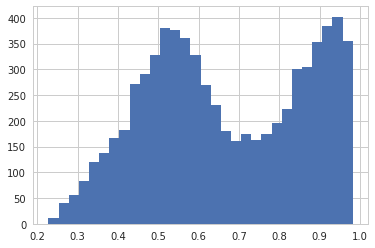

In [22]:
plt.hist(test_predictions, bins=30)
plt.show()

In [40]:
pos_example_idxs_test = np.flatnonzero(test_predictions >= pos_threshold)
neg_example_idxs_test = np.flatnonzero(test_predictions <= neg_threshold)

print('# interesting pos, X_test: ', len(pos_example_idxs_test))
print('# interesting neg, X_test: ', len(neg_example_idxs_test))

# interesting pos, X_test:  1881
# interesting neg, X_test:  1019


In [31]:
brc_test = BeerReviewContainer(embeddings, index_to_token, ASPECT, model_path, 0)

In [32]:
for i in pos_example_idxs_test:
    x = X_test[i]
    review = BeerReview(x, i, embeddings=embeddings)
    review.threshold = pos_threshold
    review.threshold_f = threshold_pos_f
    review.is_pos = True
    brc_test.add_pos_review(review)

for i in neg_example_idxs_test:
    x = X_test[i]
    review = BeerReview(x, i, embeddings=embeddings)
    review.threshold = neg_threshold
    review.threshold_f = threshold_neg_f
    review.is_pos = False
    brc_test.add_neg_review(review)

In [ ]:
%%time
# Compute all sufficient rationales for each review
for review in brc_test.get_all_reviews():
    review.run_sis_rationales(embed_model, first_only=False, verbose=False)

In [ ]:
BRC_TEST_DIR = '../rationale_results/beer_reviews/asp1_test_lstm'

In [ ]:
# Save Test BRC to file
brc_test.dump_data(BRC_TEST_DIR)

In [ ]:
brc_test = BeerReviewContainer.load_data(BRC_TEST_DIR)